In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-07-26 07:34:51.184803


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-9.2302)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(7.9096)
penalty_target_min tensor(-11.4313) penalty_target_max tensor(6.4622)
train_loss:  -7.891254965591431
valid_loss:  -7.821442443084718
h_min_tilde -11.431299 ell_tilde -7.877292461090088 kappa_tilde 0.0005304456300582811


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.429340839385986

 2 4.8176023960113525

 3 5.10072660446167

 4 3.4833736419677734

 5 3.498241662979126

 6 3.5997228622436523

 7 3.5721168518066406

 8 3.478832721710205

 9 3.651689291000366

 10 3.696188449859619

 11 3.396524667739868

 12 3.5756661891937256

 13 3.569281816482544

 14 3.6553564071655273

 15 3.441960096359253

 16 3.5440542697906494

 17 3.6458137035369873

 18 3.493690013885498

 19 3.4941787719726562

 20 6.888760566711426

 21 7.580904960632324

 22 7.3619115352630615

 23 4.018023490905762

 24 3.7131400108337402

 25 3.8153164386749268

 26 3.5029380321502686

 27 3.6995749473571777

 28 3.5316810607910156

 29 3.6666817665100098

 30 3.621464490890503

 31 3.721402883529663

 32 3.5552682876586914

 33 3.66660475730896

 34 3.7760956287384033

 35 3.658881187438965

 36 3.764864206314087

 37 3.766347885131836

 38 3.7925257682800293

 39 3.705752372741699

 40 3.986863613128662

 41 3.9162139892578125

 42 3.6557068824768066

 43 3.647571086883545



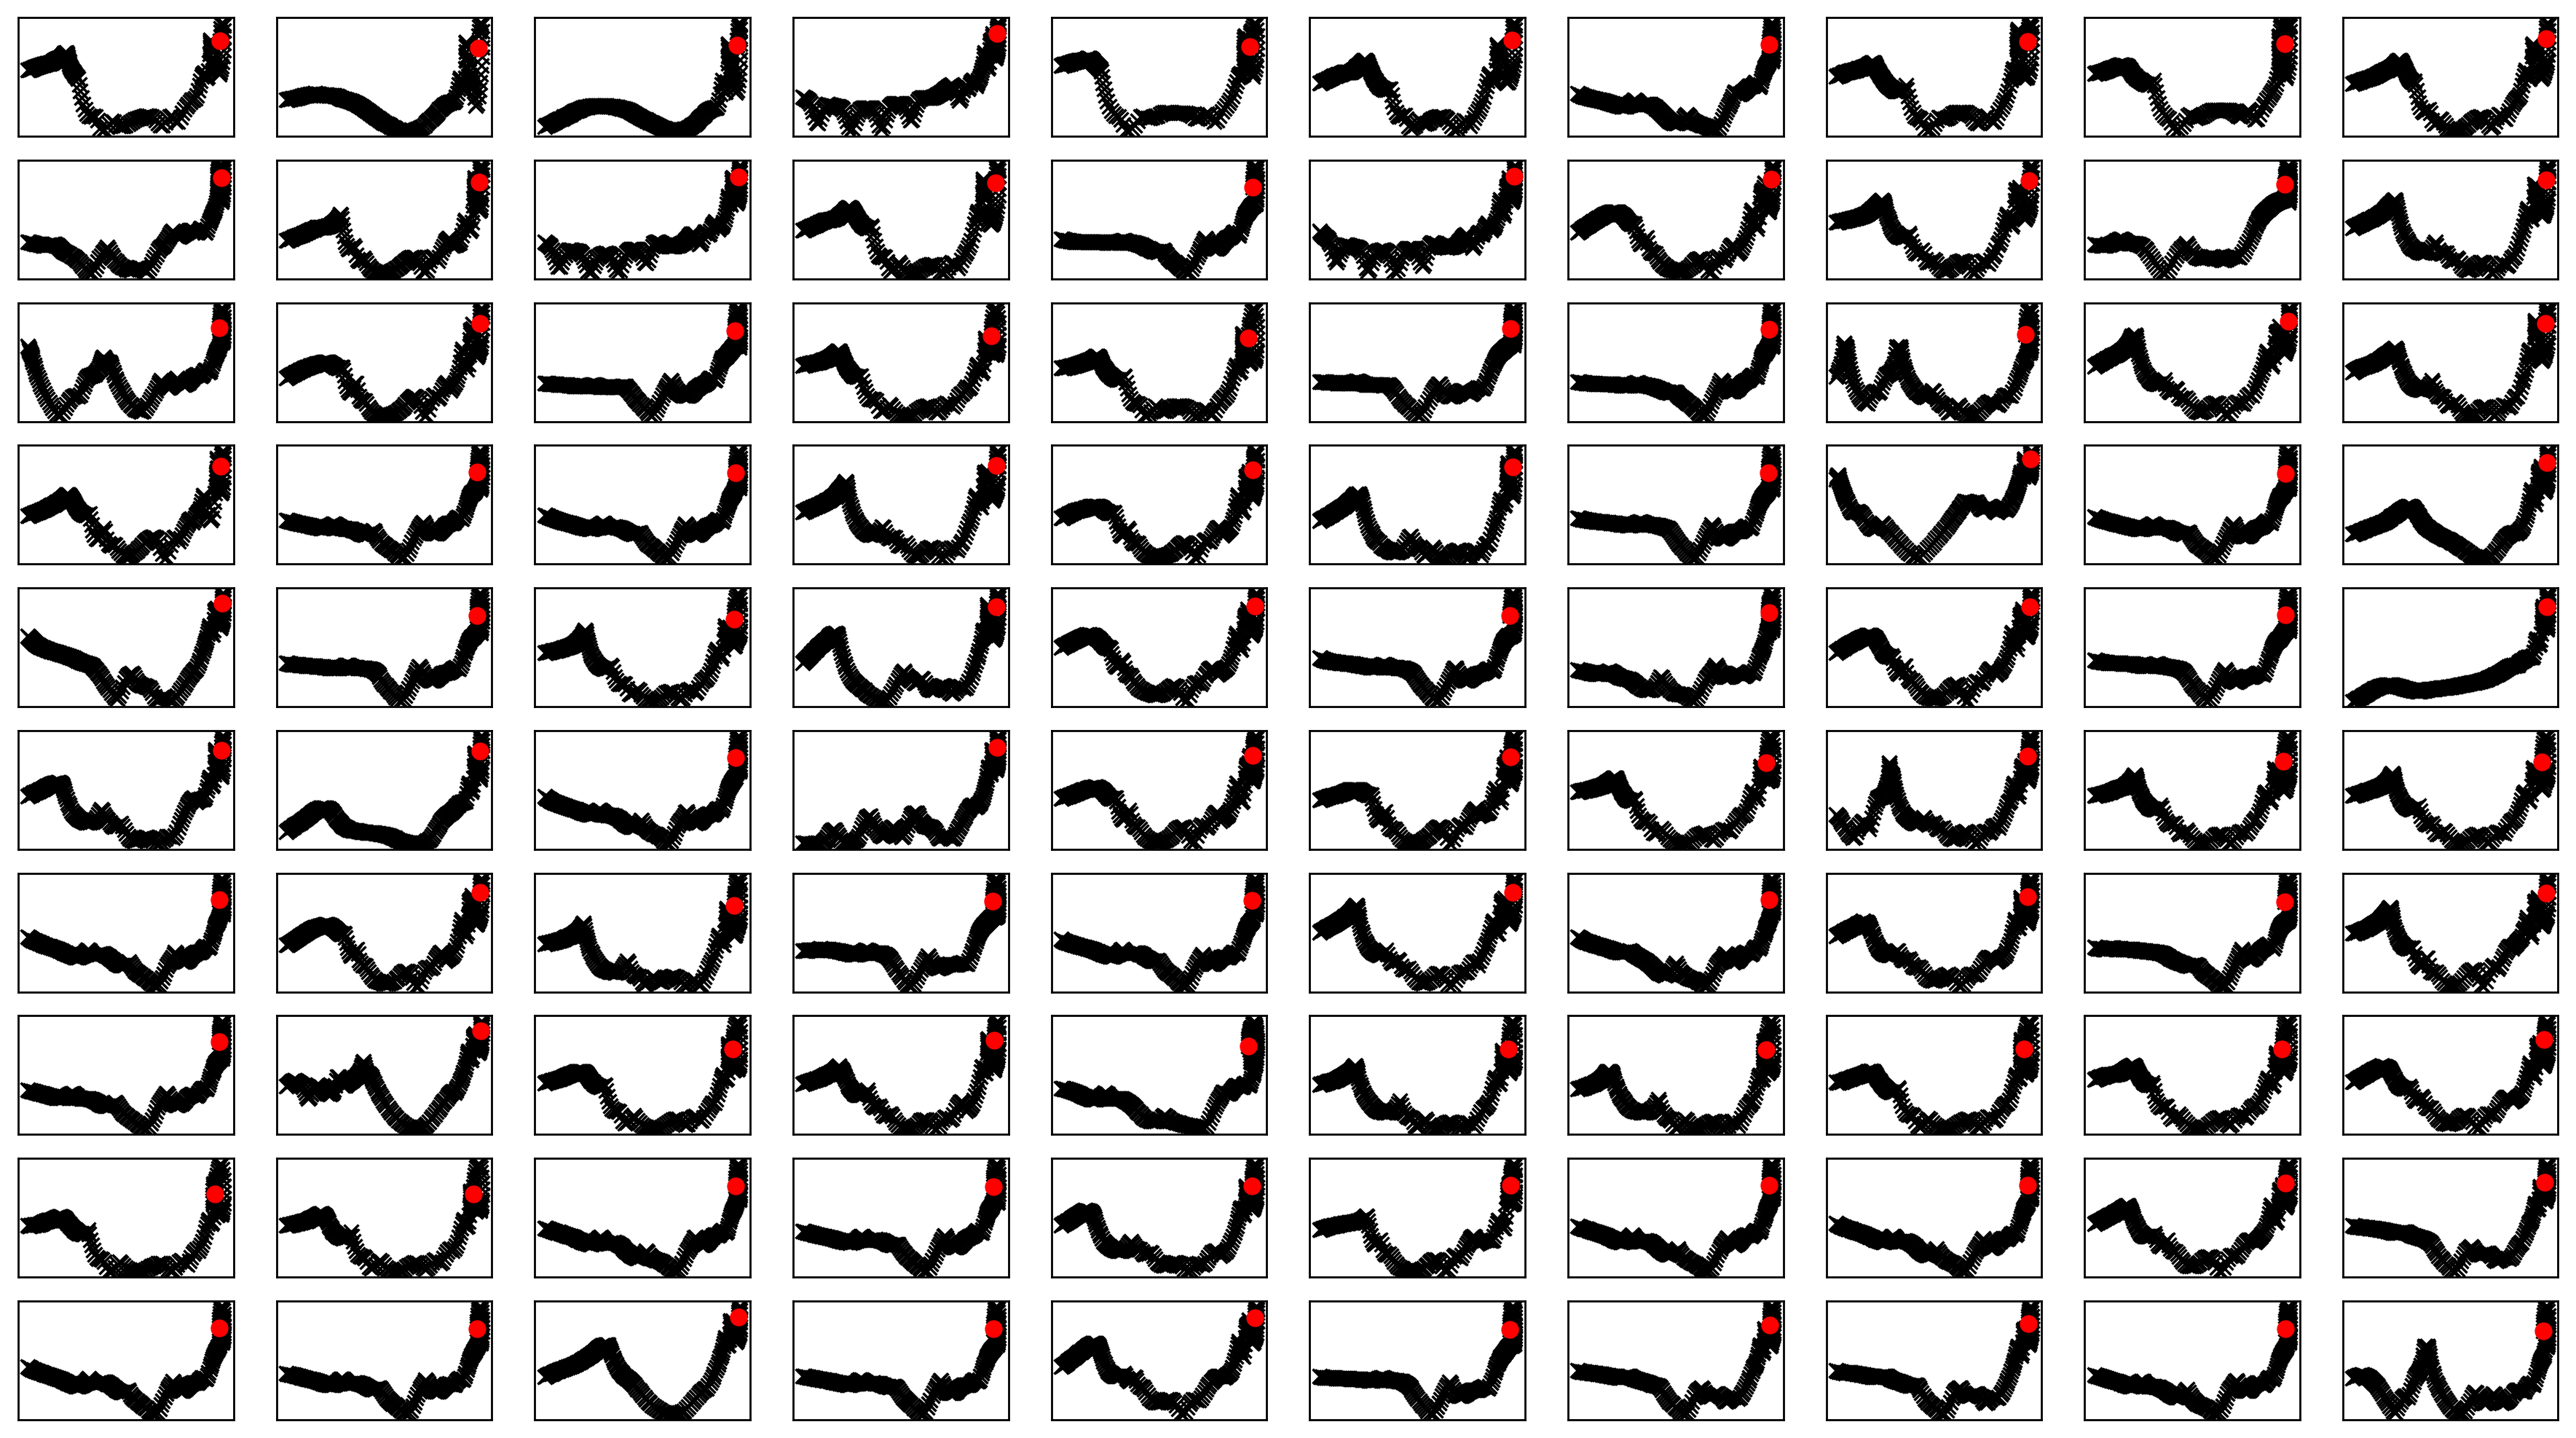

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

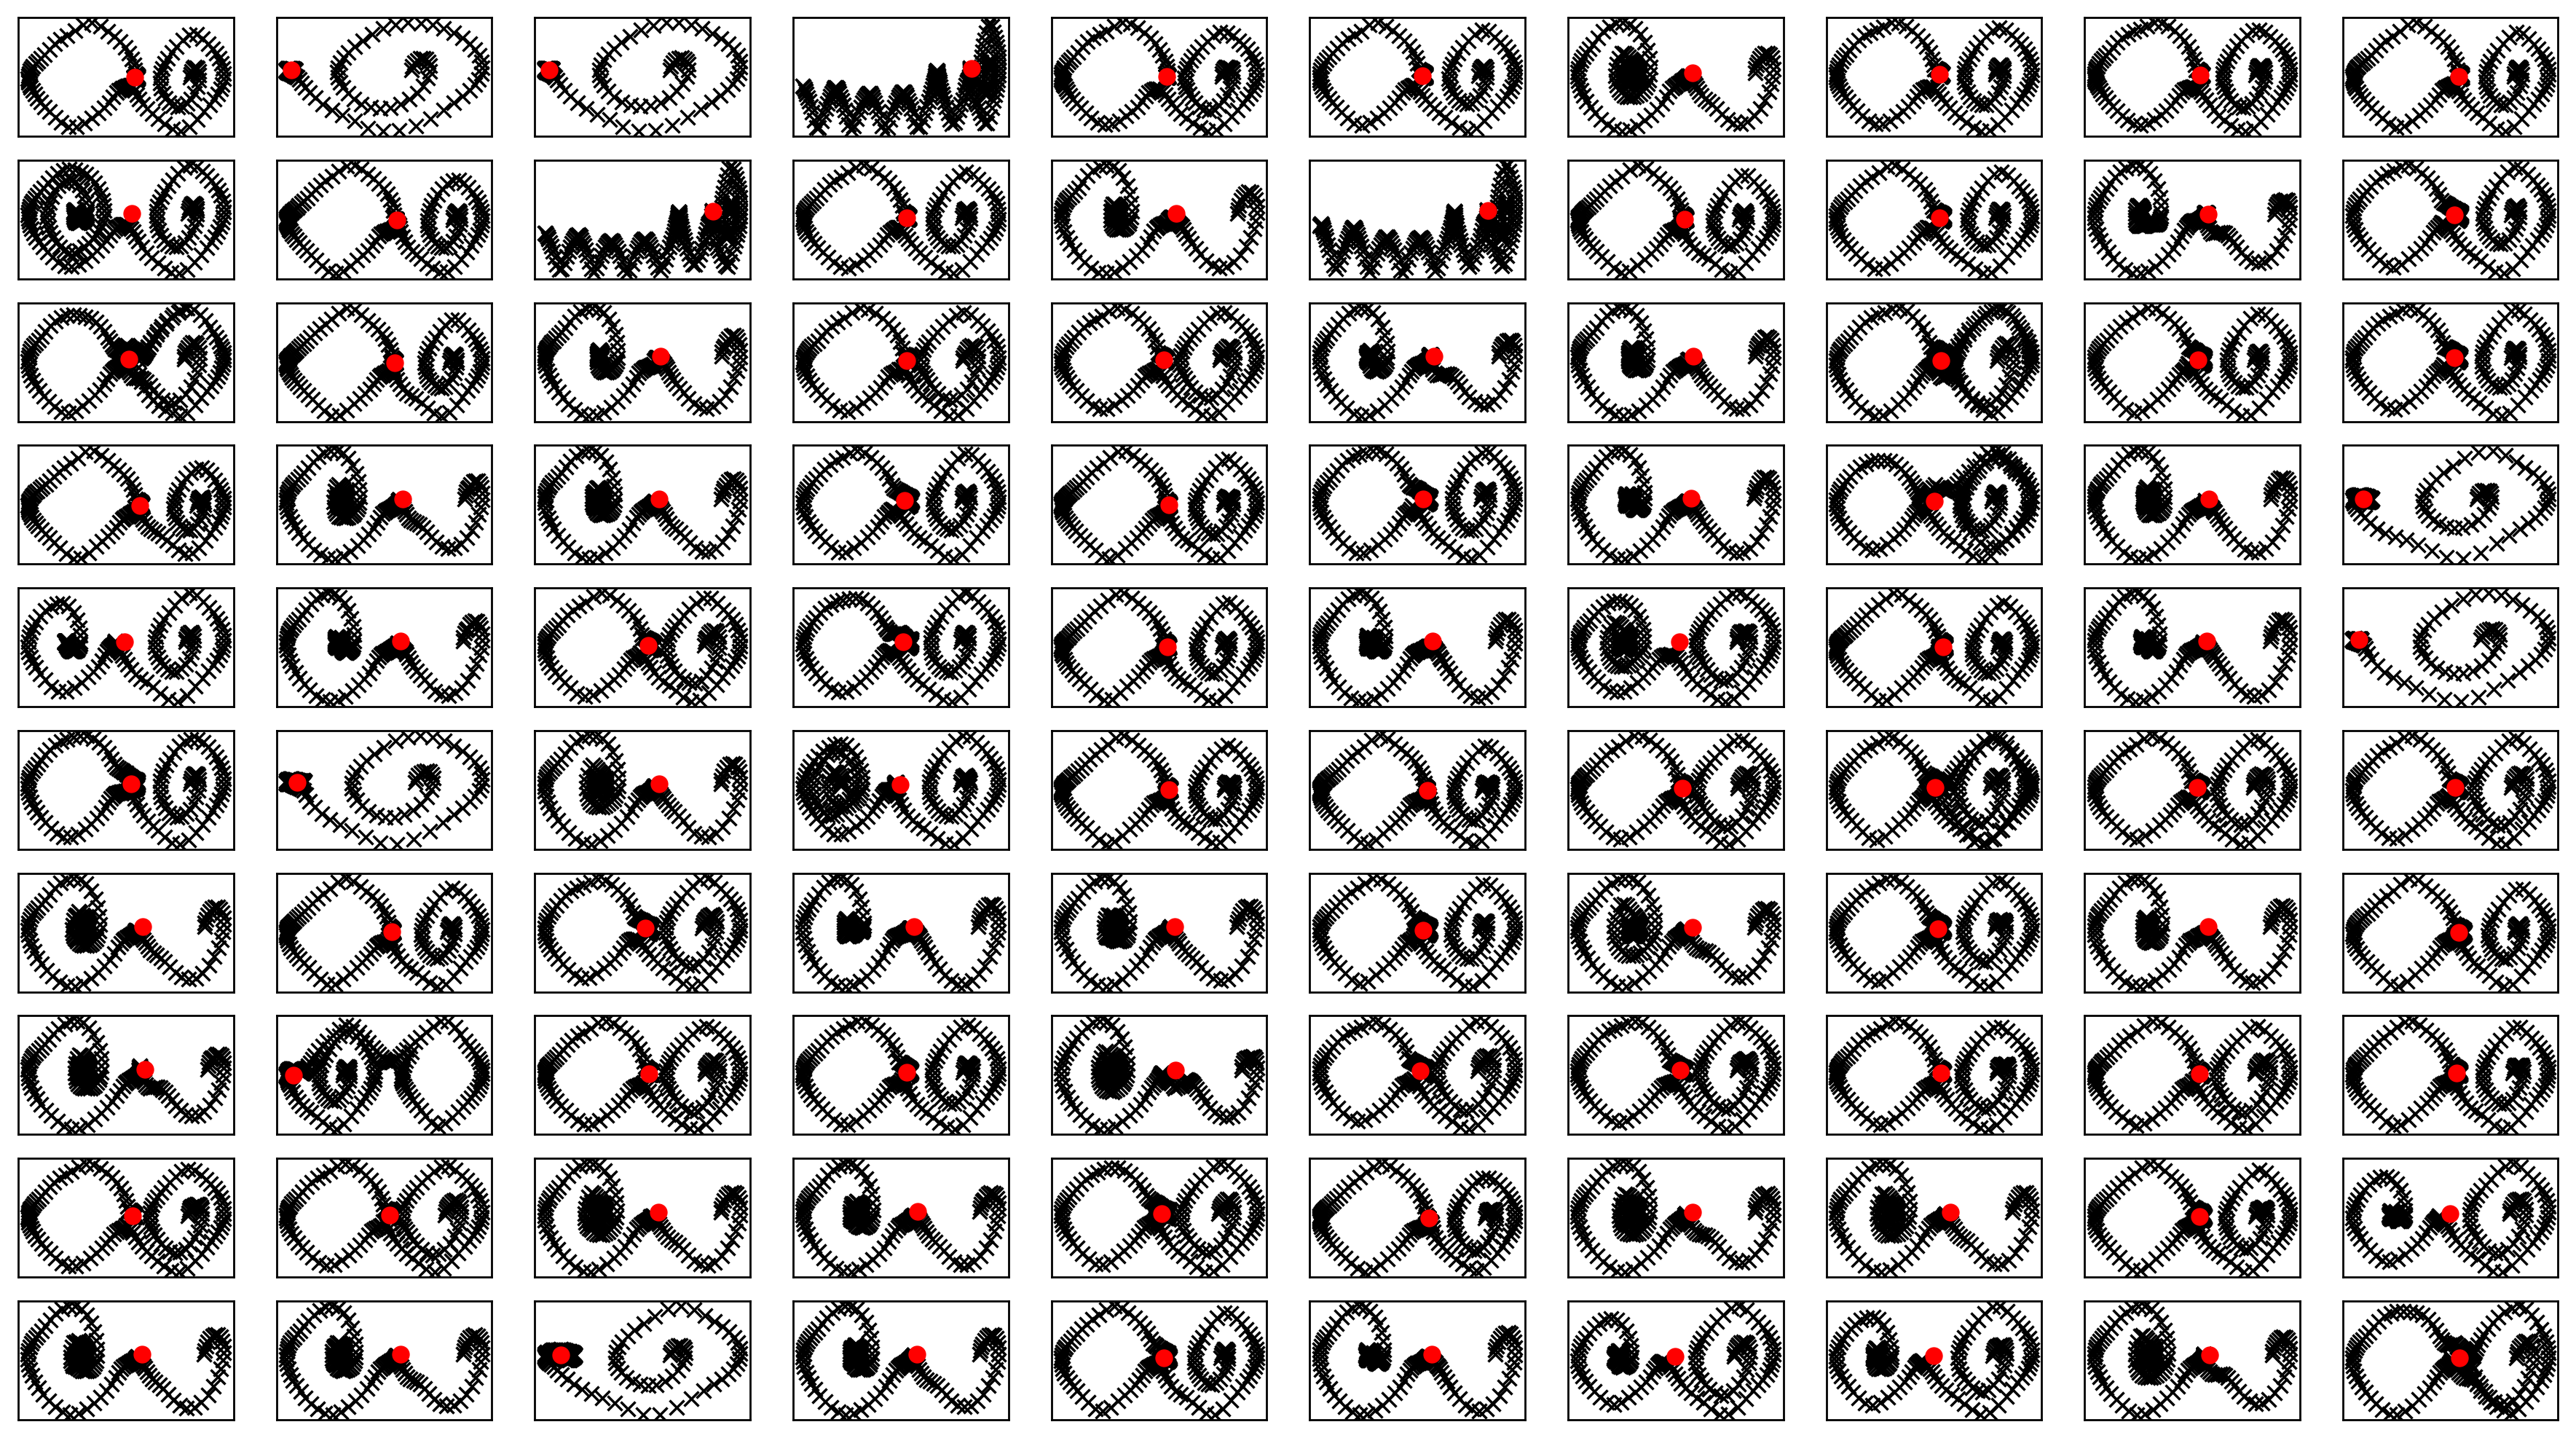

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-07-26 07:41:43.381404


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39
predict diverge [-46.82608871 -17.56623816   0.25447371   2.68843127] [-0.80725622 -0.63379208  0.10222485  0.96228288] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 162

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.33980  validloss 1.41395±0.00000  bestvalidloss 1.41395  last_update 0
train: iter 1  trainloss 1.22886  validloss 1.28319±0.00000  bestvalidloss 1.28319  last_update 0
train: iter 2  trainloss 1.14144  validloss 1.16876±0.00000  bestvalidloss 1.16876  last_update 0
train: iter 3  trainloss 1.06175  validloss 1.08956±0.00000  bestvalidloss 1.08956  last_update 0
train: iter 4  trainloss 0.97870  validloss 1.00716±0.00000  bestvalidloss 1.00716  last_update 0
train: iter 5  trainloss 0.91706  validloss 0.92829±0.00000  bestvalidloss 0.92829  last_update 0
train: iter 6  trainloss 0.87199  validloss 0.86431±0.00000  bestvalidloss 0.86431  last_update 0
train: iter 7  trainloss 0.82323  validloss 0.79630±0.00000  bestvalidloss 0.79630  last_update 0
train: iter 8  trainloss 0.78707  validloss 0.75580±0.00000  bestvalidloss 0.75580  last_update 0
train: iter 9  trainloss 0.76033  validloss 0.72038±0.00000  bestvalidloss 0.72038  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.48218  validloss 0.43519±0.00000  bestvalidloss 0.43500  last_update 2
train: iter 84  trainloss 0.48372  validloss 0.43902±0.00000  bestvalidloss 0.43500  last_update 3
train: iter 85  trainloss 0.47790  validloss 0.43348±0.00000  bestvalidloss 0.43348  last_update 0
train: iter 86  trainloss 0.48119  validloss 0.44324±0.00000  bestvalidloss 0.43348  last_update 1
train: iter 87  trainloss 0.47618  validloss 0.44258±0.00000  bestvalidloss 0.43348  last_update 2
train: iter 88  trainloss 0.47734  validloss 0.43139±0.00000  bestvalidloss 0.43139  last_update 0
train: iter 89  trainloss 0.47396  validloss 0.43913±0.00000  bestvalidloss 0.43139  last_update 1
train: iter 90  trainloss 0.47042  validloss 0.43122±0.00000  bestvalidloss 0.43122  last_update 0
train: iter 91  trainloss 0.46824  validloss 0.42893±0.00000  bestvalidloss 0.42893  last_update 0
train: iter 92  trainloss 0.46928  validloss 0.47201±0.00000  bestvalidloss 0.42893  last_update 1
train: ite

train: iter 166  trainloss 0.42733  validloss 0.39780±0.00000  bestvalidloss 0.38966  last_update 1
train: iter 167  trainloss 0.42520  validloss 0.39131±0.00000  bestvalidloss 0.38966  last_update 2
train: iter 168  trainloss 0.43160  validloss 0.40698±0.00000  bestvalidloss 0.38966  last_update 3
train: iter 169  trainloss 0.41476  validloss 0.41640±0.00000  bestvalidloss 0.38966  last_update 4
train: iter 170  trainloss 0.42776  validloss 0.40196±0.00000  bestvalidloss 0.38966  last_update 5
train: iter 171  trainloss 0.42031  validloss 0.40367±0.00000  bestvalidloss 0.38966  last_update 6
train: iter 172  trainloss 0.42208  validloss 0.38904±0.00000  bestvalidloss 0.38904  last_update 0
train: iter 173  trainloss 0.41858  validloss 0.39873±0.00000  bestvalidloss 0.38904  last_update 1
train: iter 174  trainloss 0.41626  validloss 0.39167±0.00000  bestvalidloss 0.38904  last_update 2
train: iter 175  trainloss 0.44021  validloss 0.51118±0.00000  bestvalidloss 0.38904  last_update 3


train: iter 248  trainloss 0.39162  validloss 0.36743±0.00000  bestvalidloss 0.35578  last_update 1
train: iter 249  trainloss 0.38946  validloss 0.38066±0.00000  bestvalidloss 0.35578  last_update 2
train: iter 250  trainloss 0.38734  validloss 0.36893±0.00000  bestvalidloss 0.35578  last_update 3
train: iter 251  trainloss 0.38980  validloss 0.37361±0.00000  bestvalidloss 0.35578  last_update 4
train: iter 252  trainloss 0.39346  validloss 0.38720±0.00000  bestvalidloss 0.35578  last_update 5
train: iter 253  trainloss 0.38619  validloss 0.36554±0.00000  bestvalidloss 0.35578  last_update 6
train: iter 254  trainloss 0.38858  validloss 0.35990±0.00000  bestvalidloss 0.35578  last_update 7
train: iter 255  trainloss 0.38467  validloss 0.37874±0.00000  bestvalidloss 0.35578  last_update 8
train: iter 256  trainloss 0.38496  validloss 0.35812±0.00000  bestvalidloss 0.35578  last_update 9
train: iter 257  trainloss 0.39531  validloss 0.36375±0.00000  bestvalidloss 0.35578  last_update 10

train: iter 330  trainloss 0.37065  validloss 0.34706±0.00000  bestvalidloss 0.34078  last_update 19
train: iter 331  trainloss 0.36233  validloss 0.35190±0.00000  bestvalidloss 0.34078  last_update 20
train: iter 332  trainloss 0.36504  validloss 0.34342±0.00000  bestvalidloss 0.34078  last_update 21
train: iter 333  trainloss 0.36057  validloss 0.35165±0.00000  bestvalidloss 0.34078  last_update 22
train: iter 334  trainloss 0.36366  validloss 0.33897±0.00000  bestvalidloss 0.33897  last_update 0
train: iter 335  trainloss 0.36837  validloss 0.34285±0.00000  bestvalidloss 0.33897  last_update 1
train: iter 336  trainloss 0.36259  validloss 0.34172±0.00000  bestvalidloss 0.33897  last_update 2
train: iter 337  trainloss 0.37233  validloss 0.33930±0.00000  bestvalidloss 0.33897  last_update 3
train: iter 338  trainloss 0.36473  validloss 0.33370±0.00000  bestvalidloss 0.33370  last_update 0
train: iter 339  trainloss 0.36301  validloss 0.37347±0.00000  bestvalidloss 0.33370  last_updat

train: iter 412  trainloss 0.34660  validloss 0.34072±0.00000  bestvalidloss 0.33008  last_update 27
train: iter 413  trainloss 0.35010  validloss 0.34215±0.00000  bestvalidloss 0.33008  last_update 28
train: iter 414  trainloss 0.34347  validloss 0.34257±0.00000  bestvalidloss 0.33008  last_update 29
train: iter 415  trainloss 0.35097  validloss 0.34252±0.00000  bestvalidloss 0.33008  last_update 30
train: iter 416  trainloss 0.34763  validloss 0.33459±0.00000  bestvalidloss 0.33008  last_update 31
train: iter 417  trainloss 0.35513  validloss 0.34881±0.00000  bestvalidloss 0.33008  last_update 32
train: iter 418  trainloss 0.34598  validloss 0.35064±0.00000  bestvalidloss 0.33008  last_update 33
train: iter 419  trainloss 0.34139  validloss 0.34500±0.00000  bestvalidloss 0.33008  last_update 34
train: iter 420  trainloss 0.34946  validloss 0.33942±0.00000  bestvalidloss 0.33008  last_update 35
train: iter 421  trainloss 0.35597  validloss 0.35017±0.00000  bestvalidloss 0.33008  last_

train: iter 494  trainloss 0.33448  validloss 0.35117±0.00000  bestvalidloss 0.32671  last_update 1
train: iter 495  trainloss 0.33233  validloss 0.34019±0.00000  bestvalidloss 0.32671  last_update 2
train: iter 496  trainloss 0.33640  validloss 0.32962±0.00000  bestvalidloss 0.32671  last_update 3
train: iter 497  trainloss 0.32954  validloss 0.33812±0.00000  bestvalidloss 0.32671  last_update 4
train: iter 498  trainloss 0.33036  validloss 0.34086±0.00000  bestvalidloss 0.32671  last_update 5
train: iter 499  trainloss 0.32941  validloss 0.34517±0.00000  bestvalidloss 0.32671  last_update 6
train: iter 500  trainloss 0.33291  validloss 0.33691±0.00000  bestvalidloss 0.32671  last_update 7
train: iter 501  trainloss 0.33486  validloss 0.34757±0.00000  bestvalidloss 0.32671  last_update 8
train: iter 502  trainloss 0.33619  validloss 0.33635±0.00000  bestvalidloss 0.32671  last_update 9
train: iter 503  trainloss 0.33552  validloss 0.33119±0.00000  bestvalidloss 0.32671  last_update 10

train: iter 577  trainloss 0.31780  validloss 0.33125±0.00000  bestvalidloss 0.32534  last_update 59
train: iter 578  trainloss 0.32215  validloss 0.32965±0.00000  bestvalidloss 0.32534  last_update 60
train: iter 579  trainloss 0.32253  validloss 0.33339±0.00000  bestvalidloss 0.32534  last_update 61
train: iter 580  trainloss 0.33002  validloss 0.32984±0.00000  bestvalidloss 0.32534  last_update 62
train: iter 581  trainloss 0.31723  validloss 0.33775±0.00000  bestvalidloss 0.32534  last_update 63
train: iter 582  trainloss 0.32660  validloss 0.33314±0.00000  bestvalidloss 0.32534  last_update 64
train: iter 583  trainloss 0.32039  validloss 0.33146±0.00000  bestvalidloss 0.32534  last_update 65
train: iter 584  trainloss 0.32214  validloss 0.33605±0.00000  bestvalidloss 0.32534  last_update 66
train: iter 585  trainloss 0.31853  validloss 0.33688±0.00000  bestvalidloss 0.32534  last_update 67
train: iter 586  trainloss 0.32450  validloss 0.33024±0.00000  bestvalidloss 0.32534  last_

train: iter 659  trainloss 0.31475  validloss 0.32481±0.00000  bestvalidloss 0.32481  last_update 0
train: iter 660  trainloss 0.30845  validloss 0.34321±0.00000  bestvalidloss 0.32481  last_update 1
train: iter 661  trainloss 0.31260  validloss 0.33259±0.00000  bestvalidloss 0.32481  last_update 2
train: iter 662  trainloss 0.30953  validloss 0.34290±0.00000  bestvalidloss 0.32481  last_update 3
train: iter 663  trainloss 0.31369  validloss 0.32808±0.00000  bestvalidloss 0.32481  last_update 4
train: iter 664  trainloss 0.30852  validloss 0.36999±0.00000  bestvalidloss 0.32481  last_update 5
train: iter 665  trainloss 0.31185  validloss 0.33181±0.00000  bestvalidloss 0.32481  last_update 6
train: iter 666  trainloss 0.31127  validloss 0.33225±0.00000  bestvalidloss 0.32481  last_update 7
train: iter 667  trainloss 0.31074  validloss 0.33327±0.00000  bestvalidloss 0.32481  last_update 8
train: iter 668  trainloss 0.31251  validloss 0.33173±0.00000  bestvalidloss 0.32481  last_update 9


train: iter 742  trainloss 0.30124  validloss 0.33347±0.00000  bestvalidloss 0.32116  last_update 12
train: iter 743  trainloss 0.30056  validloss 0.32833±0.00000  bestvalidloss 0.32116  last_update 13
train: iter 744  trainloss 0.30264  validloss 0.33997±0.00000  bestvalidloss 0.32116  last_update 14
train: iter 745  trainloss 0.30313  validloss 0.34117±0.00000  bestvalidloss 0.32116  last_update 15
train: iter 746  trainloss 0.30043  validloss 0.33166±0.00000  bestvalidloss 0.32116  last_update 16
train: iter 747  trainloss 0.31556  validloss 0.32945±0.00000  bestvalidloss 0.32116  last_update 17
train: iter 748  trainloss 0.30161  validloss 0.32567±0.00000  bestvalidloss 0.32116  last_update 18
train: iter 749  trainloss 0.30344  validloss 0.32508±0.00000  bestvalidloss 0.32116  last_update 19
train: iter 750  trainloss 0.29999  validloss 0.32737±0.00000  bestvalidloss 0.32116  last_update 20
train: iter 751  trainloss 0.29883  validloss 0.34001±0.00000  bestvalidloss 0.32116  last_

train: iter 824  trainloss 0.29294  validloss 0.32849±0.00000  bestvalidloss 0.32116  last_update 94
train: iter 825  trainloss 0.29572  validloss 0.33855±0.00000  bestvalidloss 0.32116  last_update 95
train: iter 826  trainloss 0.29277  validloss 0.33174±0.00000  bestvalidloss 0.32116  last_update 96
train: iter 827  trainloss 0.29857  validloss 0.33227±0.00000  bestvalidloss 0.32116  last_update 97
train: iter 828  trainloss 0.29729  validloss 0.32276±0.00000  bestvalidloss 0.32116  last_update 98
train: iter 829  trainloss 0.29489  validloss 0.33477±0.00000  bestvalidloss 0.32116  last_update 99
train: iter 830  trainloss 0.29717  validloss 0.34455±0.00000  bestvalidloss 0.32116  last_update 100
train: fin


In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -2.680263215404749
valid_loss:  -2.9732595129966737
weight_alpha 1.0 h_min_tilde -11.431299 ell_tilde -2.7388624749231343 kappa_tilde 0.00033917921503857955
train_loss:  -3.6717173919200903
valid_loss:  -3.710089102554322
weight_alpha 0.1 h_min_tilde -11.431299 ell_tilde -3.6793917340469364 kappa_tilde 0.0003591664066994679


In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -717.23746  validloss -740.84734±0.00000  bestvalidloss -740.84734  last_update 0
train: iter 1  trainloss -721.65648  validloss -721.66957±0.00000  bestvalidloss -740.84734  last_update 1
train: iter 2  trainloss -718.17952  validloss -725.15284±0.00000  bestvalidloss -740.84734  last_update 2
train: iter 3  trainloss -726.37908  validloss -712.64889±0.00000  bestvalidloss -740.84734  last_update 3
train: iter 4  trainloss -724.17491  validloss -714.49521±0.00000  bestvalidloss -740.84734  last_update 4
train: iter 5  trainloss -729.11867  validloss -738.70849±0.00000  bestvalidloss -740.84734  last_update 5
train: iter 6  trainloss -647.37044  validloss -748.34906±0.00000  bestvalidloss -748.34906  last_update 0
train: iter 7  trainloss -712.30521  validloss -655.38633±0.00000  bestvalidloss -748.34906  last_update 1
train: iter 8  trainloss -709.27509  validloss -631.33791±0.00000  bestvalidloss -748.34906  last_u

train: iter 76  trainloss -794.71158  validloss -707.43382±0.00000  bestvalidloss -794.60471  last_update 13
train: iter 77  trainloss -818.42575  validloss -746.93590±0.00000  bestvalidloss -794.60471  last_update 14
train: iter 78  trainloss -804.82955  validloss -785.39641±0.00000  bestvalidloss -794.60471  last_update 15
train: iter 79  trainloss -818.86495  validloss -772.80101±0.00000  bestvalidloss -794.60471  last_update 16
train: iter 80  trainloss -817.69887  validloss -767.28249±0.00000  bestvalidloss -794.60471  last_update 17
train: iter 81  trainloss -779.76906  validloss -633.41141±0.00000  bestvalidloss -794.60471  last_update 18
train: iter 82  trainloss -819.37551  validloss -743.30401±0.00000  bestvalidloss -794.60471  last_update 19
train: iter 83  trainloss -827.04297  validloss -735.69487±0.00000  bestvalidloss -794.60471  last_update 20
train: iter 84  trainloss -813.64340  validloss -777.63965±0.00000  bestvalidloss -794.60471  last_update 21
train: iter 85  tra

train: iter 151  trainloss -707.16782  validloss -591.01611±0.00000  bestvalidloss -822.41844  last_update 32
train: iter 152  trainloss -755.38009  validloss -712.52749±0.00000  bestvalidloss -822.41844  last_update 33
train: iter 153  trainloss -781.34441  validloss -749.60698±0.00000  bestvalidloss -822.41844  last_update 34
train: iter 154  trainloss -786.13789  validloss -756.94507±0.00000  bestvalidloss -822.41844  last_update 35
train: iter 155  trainloss -781.80975  validloss -756.81194±0.00000  bestvalidloss -822.41844  last_update 36
train: iter 156  trainloss -762.61292  validloss -749.46834±0.00000  bestvalidloss -822.41844  last_update 37
train: iter 157  trainloss -750.69513  validloss -692.00443±0.00000  bestvalidloss -822.41844  last_update 38
train: iter 158  trainloss -786.49891  validloss -738.86165±0.00000  bestvalidloss -822.41844  last_update 39
train: iter 159  trainloss -793.65830  validloss -754.71905±0.00000  bestvalidloss -822.41844  last_update 40
train: ite

train: iter 226  trainloss -885.58002  validloss -776.54698±0.00000  bestvalidloss -826.59361  last_update 9
train: iter 227  trainloss -864.76369  validloss -758.03197±0.00000  bestvalidloss -826.59361  last_update 10
train: iter 228  trainloss -878.86714  validloss -816.53040±0.00000  bestvalidloss -826.59361  last_update 11
train: iter 229  trainloss -905.08610  validloss -823.44929±0.00000  bestvalidloss -826.59361  last_update 12
train: iter 230  trainloss -898.71891  validloss -806.80263±0.00000  bestvalidloss -826.59361  last_update 13
train: iter 231  trainloss -912.60810  validloss -829.83628±0.00000  bestvalidloss -829.83628  last_update 0
train: iter 232  trainloss -859.59416  validloss -798.13793±0.00000  bestvalidloss -829.83628  last_update 1
train: iter 233  trainloss -887.75184  validloss -804.40863±0.00000  bestvalidloss -829.83628  last_update 2
train: iter 234  trainloss -897.96815  validloss -804.27480±0.00000  bestvalidloss -829.83628  last_update 3
train: iter 235

train: iter 301  trainloss -948.35767  validloss -845.45013±0.00000  bestvalidloss -845.45013  last_update 0
train: iter 302  trainloss -906.13938  validloss -824.39456±0.00000  bestvalidloss -845.45013  last_update 1
train: iter 303  trainloss -885.38701  validloss -783.37314±0.00000  bestvalidloss -845.45013  last_update 2
train: iter 304  trainloss -922.04391  validloss -796.56526±0.00000  bestvalidloss -845.45013  last_update 3
train: iter 305  trainloss -958.44611  validloss -794.42013±0.00000  bestvalidloss -845.45013  last_update 4
train: iter 306  trainloss -961.08166  validloss -848.28153±0.00000  bestvalidloss -848.28153  last_update 0
train: iter 307  trainloss -965.39749  validloss -834.61959±0.00000  bestvalidloss -848.28153  last_update 1
train: iter 308  trainloss -971.74014  validloss -847.82662±0.00000  bestvalidloss -848.28153  last_update 2
train: iter 309  trainloss -749.22889  validloss -849.58815±0.00000  bestvalidloss -849.58815  last_update 0
train: iter 310  tr

train: iter 376  trainloss -919.24679  validloss -839.68864±0.00000  bestvalidloss -860.59054  last_update 53
train: iter 377  trainloss -954.89310  validloss -817.89443±0.00000  bestvalidloss -860.59054  last_update 54
train: iter 378  trainloss -978.80019  validloss -829.18266±0.00000  bestvalidloss -860.59054  last_update 55
train: iter 379  trainloss -987.52015  validloss -824.78048±0.00000  bestvalidloss -860.59054  last_update 56
train: iter 380  trainloss -962.54367  validloss -824.41715±0.00000  bestvalidloss -860.59054  last_update 57
train: iter 381  trainloss -959.25682  validloss -824.19657±0.00000  bestvalidloss -860.59054  last_update 58
train: iter 382  trainloss -986.45249  validloss -858.59920±0.00000  bestvalidloss -860.59054  last_update 59
train: iter 383  trainloss -941.32344  validloss -812.31870±0.00000  bestvalidloss -860.59054  last_update 60
train: iter 384  trainloss -943.53999  validloss -819.70585±0.00000  bestvalidloss -860.59054  last_update 61
train: ite

train: iter 451  trainloss -974.50349  validloss -779.29193±0.00000  bestvalidloss -873.38250  last_update 19
train: iter 452  trainloss -1014.49284  validloss -851.20891±0.00000  bestvalidloss -873.38250  last_update 20
train: iter 453  trainloss -987.84781  validloss -851.07055±0.00000  bestvalidloss -873.38250  last_update 21
train: iter 454  trainloss -994.51583  validloss -844.43581±0.00000  bestvalidloss -873.38250  last_update 22
train: iter 455  trainloss -924.78739  validloss -820.84661±0.00000  bestvalidloss -873.38250  last_update 23
train: iter 456  trainloss -970.90100  validloss -850.91484±0.00000  bestvalidloss -873.38250  last_update 24
train: iter 457  trainloss -1004.84736  validloss -818.45573±0.00000  bestvalidloss -873.38250  last_update 25
train: iter 458  trainloss -996.47688  validloss -881.33919±0.00000  bestvalidloss -881.33919  last_update 0
train: iter 459  trainloss -997.55272  validloss -850.02142±0.00000  bestvalidloss -881.33919  last_update 1
train: ite

train: iter 526  trainloss -995.94703  validloss -825.64271±0.00000  bestvalidloss -881.33919  last_update 68
train: iter 527  trainloss -1008.48774  validloss -846.26523±0.00000  bestvalidloss -881.33919  last_update 69
train: iter 528  trainloss -1008.11325  validloss -849.32491±0.00000  bestvalidloss -881.33919  last_update 70
train: iter 529  trainloss -1023.30448  validloss -839.99459±0.00000  bestvalidloss -881.33919  last_update 71
train: iter 530  trainloss -1011.85003  validloss -820.88715±0.00000  bestvalidloss -881.33919  last_update 72
train: iter 531  trainloss -986.86320  validloss -847.97944±0.00000  bestvalidloss -881.33919  last_update 73
train: iter 532  trainloss -978.29881  validloss -819.81902±0.00000  bestvalidloss -881.33919  last_update 74
train: iter 533  trainloss -1018.02780  validloss -858.79981±0.00000  bestvalidloss -881.33919  last_update 75
train: iter 534  trainloss -1017.51087  validloss -858.14217±0.00000  bestvalidloss -881.33919  last_update 76
trai

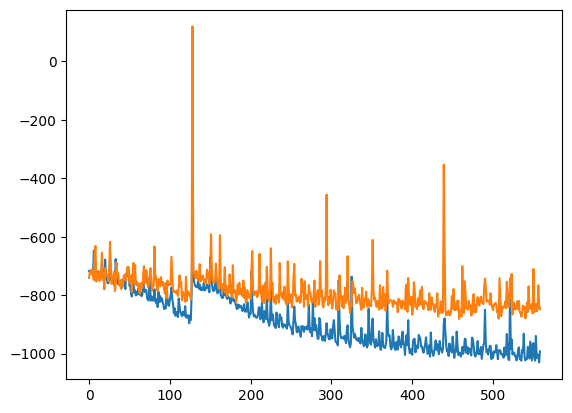

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-07-26 08:10:33.020553


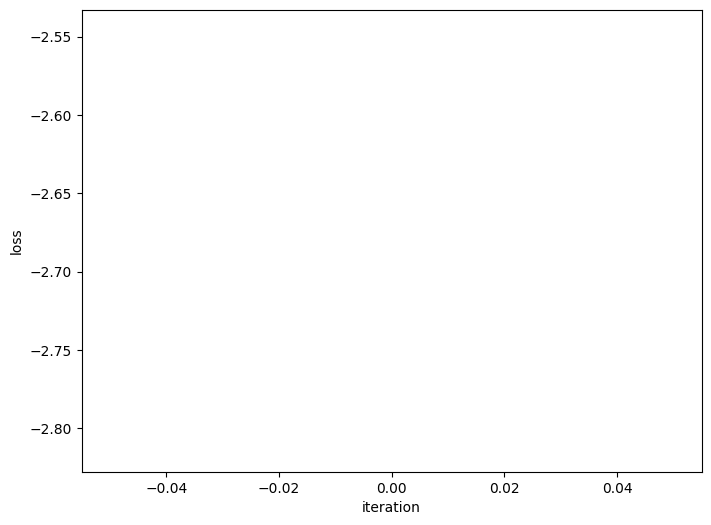

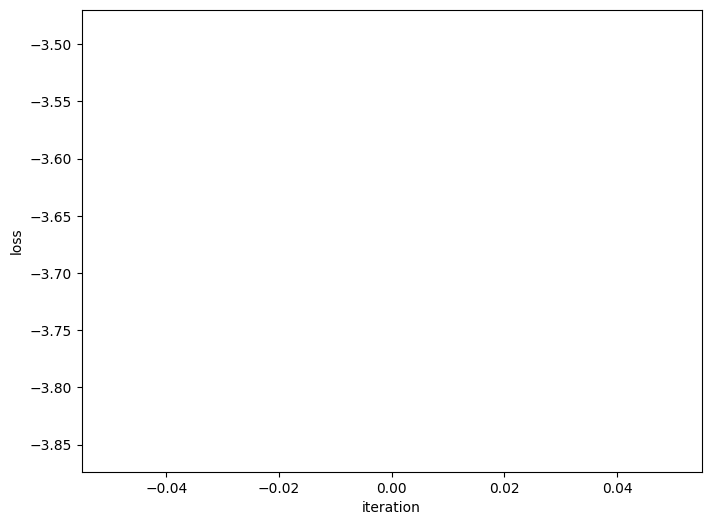

In [17]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# Iter2

In [18]:
policy_evaluation_iter=1

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [ -63.20823187  -10.60705892  -16.33590744 -226.26246321] [  -0.86874346    4.51610178    1.58428084 -254.04735774] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 195
predict diverge [-50.72666658  -8.71659065 -26.08453046 -50.54202658] [ -0.4266707    0.16242169   0.97268412 -68.21238723] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 161

 1

 2

 3

 4

 5

 6

 7

 8
predict diverge [-43.94004481 -17.53827943 -30.17251103  13.89116028] [-0.94741507 -0.59740729  0.56524375  5.25497334] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 149

 9

 10

 11
predict diverge [-44.65515361  -7.23671975 -18.90295355  34.18916284] [-0.23503455 -0.60706662  0.54800313 22.02880557] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 163

 

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.19529  validloss 3.79369±0.00000  bestvalidloss 3.79369  last_update 0
train: iter 1  trainloss 0.69628  validloss 0.57223±0.00000  bestvalidloss 0.57223  last_update 0
train: iter 2  trainloss 0.61776  validloss 0.48350±0.00000  bestvalidloss 0.48350  last_update 0
train: iter 3  trainloss 0.58196  validloss 0.46219±0.00000  bestvalidloss 0.46219  last_update 0
train: iter 4  trainloss 0.55108  validloss 0.44525±0.00000  bestvalidloss 0.44525  last_update 0
train: iter 5  trainloss 0.53278  validloss 0.44822±0.00000  bestvalidloss 0.44525  last_update 1
train: iter 6  trainloss 0.51741  validloss 0.45801±0.00000  bestvalidloss 0.44525  last_update 2
train: iter 7  trainloss 0.50780  validloss 0.44013±0.00000  bestvalidloss 0.44013  last_update 0
train: iter 8  trainloss 0.50269  validloss 0.45833±0.00000  bestvalidloss 0.44013  last_update 1
train: iter 9  trainloss 0.49425  validloss 0.42530±0.00000  bestvalidloss 0.42530  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.38350  validloss 0.40205±0.00000  bestvalidloss 0.38258  last_update 5
train: iter 84  trainloss 0.38487  validloss 0.38814±0.00000  bestvalidloss 0.38258  last_update 6
train: iter 85  trainloss 0.38282  validloss 0.39331±0.00000  bestvalidloss 0.38258  last_update 7
train: iter 86  trainloss 0.38079  validloss 0.39144±0.00000  bestvalidloss 0.38258  last_update 8
train: iter 87  trainloss 0.37905  validloss 0.40306±0.00000  bestvalidloss 0.38258  last_update 9
train: iter 88  trainloss 0.38934  validloss 0.40556±0.00000  bestvalidloss 0.38258  last_update 10
train: iter 89  trainloss 0.38392  validloss 0.38810±0.00000  bestvalidloss 0.38258  last_update 11
train: iter 90  trainloss 0.38447  validloss 0.37935±0.00000  bestvalidloss 0.37935  last_update 0
train: iter 91  trainloss 0.38565  validloss 0.39081±0.00000  bestvalidloss 0.37935  last_update 1
train: iter 92  trainloss 0.38089  validloss 0.39421±0.00000  bestvalidloss 0.37935  last_update 2
train: i

train: iter 166  trainloss 0.35805  validloss 0.38421±0.00000  bestvalidloss 0.36874  last_update 12
train: iter 167  trainloss 0.35619  validloss 0.37061±0.00000  bestvalidloss 0.36874  last_update 13
train: iter 168  trainloss 0.35727  validloss 0.36680±0.00000  bestvalidloss 0.36680  last_update 0
train: iter 169  trainloss 0.35470  validloss 0.37941±0.00000  bestvalidloss 0.36680  last_update 1
train: iter 170  trainloss 0.35840  validloss 0.40044±0.00000  bestvalidloss 0.36680  last_update 2
train: iter 171  trainloss 0.35568  validloss 0.38724±0.00000  bestvalidloss 0.36680  last_update 3
train: iter 172  trainloss 0.35459  validloss 0.37455±0.00000  bestvalidloss 0.36680  last_update 4
train: iter 173  trainloss 0.35362  validloss 0.37028±0.00000  bestvalidloss 0.36680  last_update 5
train: iter 174  trainloss 0.35743  validloss 0.36317±0.00000  bestvalidloss 0.36317  last_update 0
train: iter 175  trainloss 0.35696  validloss 0.36993±0.00000  bestvalidloss 0.36317  last_update 

train: iter 248  trainloss 0.33688  validloss 0.36397±0.00000  bestvalidloss 0.36218  last_update 19
train: iter 249  trainloss 0.34138  validloss 0.36929±0.00000  bestvalidloss 0.36218  last_update 20
train: iter 250  trainloss 0.33796  validloss 0.37771±0.00000  bestvalidloss 0.36218  last_update 21
train: iter 251  trainloss 0.33915  validloss 0.37842±0.00000  bestvalidloss 0.36218  last_update 22
train: iter 252  trainloss 0.34037  validloss 0.37340±0.00000  bestvalidloss 0.36218  last_update 23
train: iter 253  trainloss 0.33750  validloss 0.37055±0.00000  bestvalidloss 0.36218  last_update 24
train: iter 254  trainloss 0.33894  validloss 0.37398±0.00000  bestvalidloss 0.36218  last_update 25
train: iter 255  trainloss 0.33425  validloss 0.37808±0.00000  bestvalidloss 0.36218  last_update 26
train: iter 256  trainloss 0.33678  validloss 0.38472±0.00000  bestvalidloss 0.36218  last_update 27
train: iter 257  trainloss 0.33857  validloss 0.37166±0.00000  bestvalidloss 0.36218  last_

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.790528402906657
valid_loss:  -4.098451561927795
weight_alpha 1.0 h_min_tilde -11.463102 ell_tilde -4.652113034710884 kappa_tilde 0.00038317300137311435
train_loss:  -4.164728133630753
valid_loss:  -3.7959275482177732
weight_alpha 0.1 h_min_tilde -11.463102 ell_tilde -4.090968016548157 kappa_tilde 0.00036830140885418496


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -849.88999  validloss -762.38033±0.00000  bestvalidloss -762.38033  last_update 0
train: iter 1  trainloss -845.77192  validloss -756.55753±0.00000  bestvalidloss -762.38033  last_update 1
train: iter 2  trainloss -861.98600  validloss -792.38293±0.00000  bestvalidloss -792.38293  last_update 0
train: iter 3  trainloss -785.00550  validloss -759.70972±0.00000  bestvalidloss -792.38293  last_update 1
train: iter 4  trainloss -852.47342  validloss -780.47367±0.00000  bestvalidloss -792.38293  last_update 2
train: iter 5  trainloss -858.62728  validloss -746.34711±0.00000  bestvalidloss -792.38293  last_update 3
train: iter 6  trainloss -832.63722  validloss -794.03600±0.00000  bestvalidloss -794.03600  last_update 0
train: iter 7  trainloss -862.31727  validloss -773.54906±0.00000  bestvalidloss -794.03600  last_update 1
train: iter 8  trainloss -869.02500  validloss -777.53343±0.00000  bestvalidloss -794.03600  last_u

train: iter 76  trainloss -859.40393  validloss -745.58612±0.00000  bestvalidloss -823.11953  last_update 17
train: iter 77  trainloss -879.37136  validloss -798.11825±0.00000  bestvalidloss -823.11953  last_update 18
train: iter 78  trainloss -875.40484  validloss -797.35102±0.00000  bestvalidloss -823.11953  last_update 19
train: iter 79  trainloss -876.04546  validloss -791.91468±0.00000  bestvalidloss -823.11953  last_update 20
train: iter 80  trainloss -876.37597  validloss -799.83064±0.00000  bestvalidloss -823.11953  last_update 21
train: iter 81  trainloss -796.04636  validloss -748.85381±0.00000  bestvalidloss -823.11953  last_update 22
train: iter 82  trainloss -866.43781  validloss -760.21034±0.00000  bestvalidloss -823.11953  last_update 23
train: iter 83  trainloss -871.64362  validloss -783.86308±0.00000  bestvalidloss -823.11953  last_update 24
train: iter 84  trainloss -859.49119  validloss -727.97200±0.00000  bestvalidloss -823.11953  last_update 25
train: iter 85  tra

train: iter 151  trainloss -852.37279  validloss -724.01952±0.00000  bestvalidloss -824.51083  last_update 48
train: iter 152  trainloss -871.10974  validloss -786.76773±0.00000  bestvalidloss -824.51083  last_update 49
train: iter 153  trainloss -879.15917  validloss -796.42627±0.00000  bestvalidloss -824.51083  last_update 50
train: iter 154  trainloss -885.31064  validloss -775.20047±0.00000  bestvalidloss -824.51083  last_update 51
train: iter 155  trainloss -879.49518  validloss -787.43878±0.00000  bestvalidloss -824.51083  last_update 52
train: iter 156  trainloss -884.86809  validloss -799.72219±0.00000  bestvalidloss -824.51083  last_update 53
train: iter 157  trainloss -865.28436  validloss -774.83264±0.00000  bestvalidloss -824.51083  last_update 54
train: iter 158  trainloss -794.03726  validloss -764.40245±0.00000  bestvalidloss -824.51083  last_update 55
train: iter 159  trainloss -856.20935  validloss -724.84180±0.00000  bestvalidloss -824.51083  last_update 56
train: ite

train: iter 226  trainloss -884.92979  validloss -806.48711±0.00000  bestvalidloss -830.89359  last_update 19
train: iter 227  trainloss -889.99492  validloss -785.46955±0.00000  bestvalidloss -830.89359  last_update 20
train: iter 228  trainloss -874.73098  validloss -790.33907±0.00000  bestvalidloss -830.89359  last_update 21
train: iter 229  trainloss -834.85152  validloss -526.51874±0.00000  bestvalidloss -830.89359  last_update 22
train: iter 230  trainloss -876.80996  validloss -742.19698±0.00000  bestvalidloss -830.89359  last_update 23
train: iter 231  trainloss -887.46675  validloss -777.22563±0.00000  bestvalidloss -830.89359  last_update 24
train: iter 232  trainloss -887.90340  validloss -782.18625±0.00000  bestvalidloss -830.89359  last_update 25
train: iter 233  trainloss -892.17635  validloss -793.51275±0.00000  bestvalidloss -830.89359  last_update 26
train: iter 234  trainloss -897.48874  validloss -784.65300±0.00000  bestvalidloss -830.89359  last_update 27
train: ite

train: iter 301  trainloss -882.19875  validloss -793.23618±0.00000  bestvalidloss -832.87014  last_update 27
train: iter 302  trainloss -902.84663  validloss -817.50501±0.00000  bestvalidloss -832.87014  last_update 28
train: iter 303  trainloss -910.47892  validloss -816.14137±0.00000  bestvalidloss -832.87014  last_update 29
train: iter 304  trainloss -907.04367  validloss -769.97326±0.00000  bestvalidloss -832.87014  last_update 30
train: iter 305  trainloss -889.92302  validloss -799.68692±0.00000  bestvalidloss -832.87014  last_update 31
train: iter 306  trainloss -908.72893  validloss -817.58444±0.00000  bestvalidloss -832.87014  last_update 32
train: iter 307  trainloss -824.56189  validloss -783.60839±0.00000  bestvalidloss -832.87014  last_update 33
train: iter 308  trainloss -861.05289  validloss -735.03431±0.00000  bestvalidloss -832.87014  last_update 34
train: iter 309  trainloss -896.83339  validloss -799.17829±0.00000  bestvalidloss -832.87014  last_update 35
train: ite

train: iter 376  trainloss -873.26464  validloss -740.86131±0.00000  bestvalidloss -845.09556  last_update 15
train: iter 377  trainloss -889.00488  validloss -782.79161±0.00000  bestvalidloss -845.09556  last_update 16
train: iter 378  trainloss -896.55248  validloss -772.57966±0.00000  bestvalidloss -845.09556  last_update 17
train: iter 379  trainloss -900.43647  validloss -769.23429±0.00000  bestvalidloss -845.09556  last_update 18
train: iter 380  trainloss -880.49291  validloss -743.98118±0.00000  bestvalidloss -845.09556  last_update 19
train: iter 381  trainloss -903.66613  validloss -799.60722±0.00000  bestvalidloss -845.09556  last_update 20
train: iter 382  trainloss -878.86808  validloss -799.41647±0.00000  bestvalidloss -845.09556  last_update 21
train: iter 383  trainloss -891.86759  validloss -771.51596±0.00000  bestvalidloss -845.09556  last_update 22
train: iter 384  trainloss -887.57653  validloss -830.86041±0.00000  bestvalidloss -845.09556  last_update 23
train: ite

train: iter 451  trainloss -884.30695  validloss -837.92522±0.00000  bestvalidloss -845.09556  last_update 90
train: iter 452  trainloss -795.91544  validloss -530.21194±0.00000  bestvalidloss -845.09556  last_update 91
train: iter 453  trainloss -899.53903  validloss -770.28309±0.00000  bestvalidloss -845.09556  last_update 92
train: iter 454  trainloss -823.61962  validloss -634.50423±0.00000  bestvalidloss -845.09556  last_update 93
train: iter 455  trainloss -881.53984  validloss -798.37604±0.00000  bestvalidloss -845.09556  last_update 94
train: iter 456  trainloss -907.93026  validloss -805.84822±0.00000  bestvalidloss -845.09556  last_update 95
train: iter 457  trainloss -902.69296  validloss -806.27663±0.00000  bestvalidloss -845.09556  last_update 96
train: iter 458  trainloss -918.15734  validloss -774.90593±0.00000  bestvalidloss -845.09556  last_update 97
train: iter 459  trainloss -913.16462  validloss -816.62788±0.00000  bestvalidloss -845.09556  last_update 98
train: ite

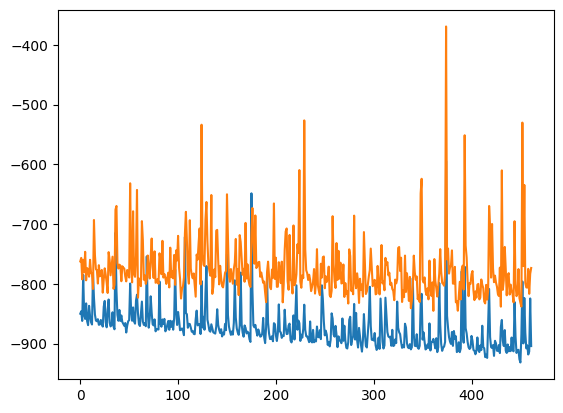

alpha 0.1 default_lr 0.0005


In [23]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [24]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [25]:
print(datetime.datetime.now())

2023-07-26 08:37:32.657852


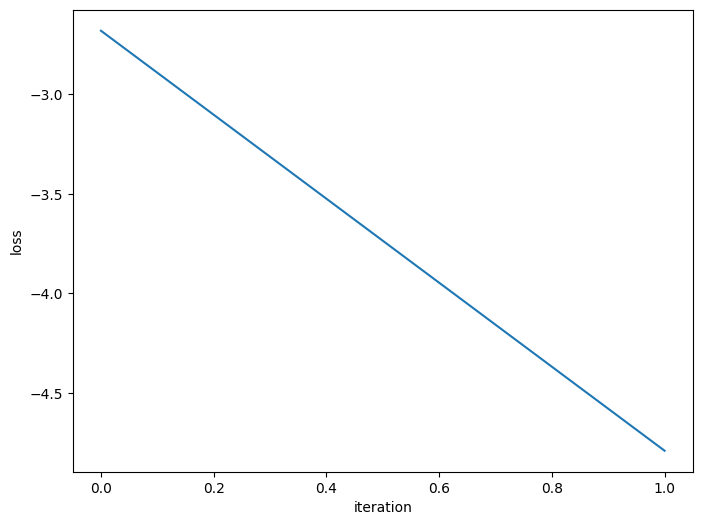

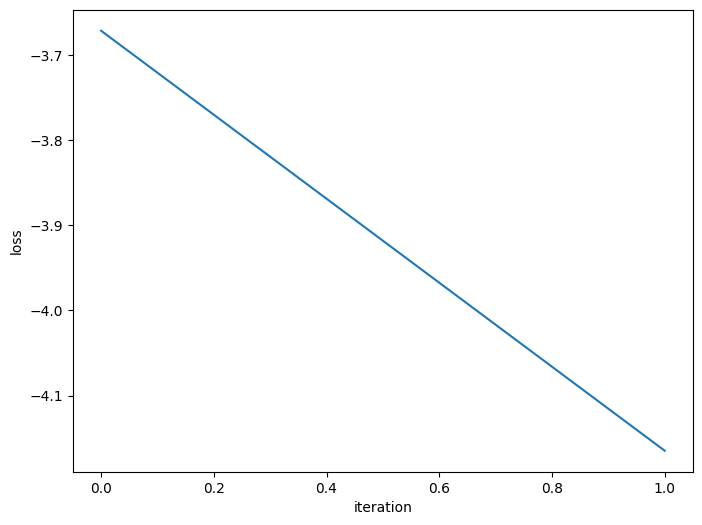

In [26]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [27]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [28]:
policy_evaluation_iter=2

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12
predict diverge [-32.59560845  -0.40814628 -19.7457732   30.64630058] [-0.36566721  3.0080286   0.73737175  9.90362239] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 138

 13

 14
predict diverge [-32.79706083 -11.48455197 -25.86923607  84.85134951] [-0.25739902 -5.35419587  1.01885882 58.90082298] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 140

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28
predict diverge [-21.62907259 -13.20332476   9.57546041  82.98214441] [-0.48187042 -4.7737765   1.51246058 53.17909503] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 123

 29

 30

 31
predict diverge [-46.57928336 -19.70723759 -27.19507389  21.92939765] [-0.85586136 -3.12357061  1.17365777 -5.48683354] [ 91.41299   17.162447 204.3865

In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.67721  validloss 0.73595±0.00000  bestvalidloss 0.73595  last_update 0
train: iter 1  trainloss 0.55442  validloss 0.46598±0.00000  bestvalidloss 0.46598  last_update 0
train: iter 2  trainloss 0.52308  validloss 0.48248±0.00000  bestvalidloss 0.46598  last_update 1
train: iter 3  trainloss 0.52068  validloss 0.45699±0.00000  bestvalidloss 0.45699  last_update 0
train: iter 4  trainloss 0.50600  validloss 0.47297±0.00000  bestvalidloss 0.45699  last_update 1
train: iter 5  trainloss 0.49078  validloss 0.45303±0.00000  bestvalidloss 0.45303  last_update 0
train: iter 6  trainloss 0.48627  validloss 0.44824±0.00000  bestvalidloss 0.44824  last_update 0
train: iter 7  trainloss 0.47846  validloss 0.46528±0.00000  bestvalidloss 0.44824  last_update 1
train: iter 8  trainloss 0.47744  validloss 0.43926±0.00000  bestvalidloss 0.43926  last_update 0
train: iter 9  trainloss 0.47686  validloss 0.44238±0.00000  bestvalidloss 0.43926  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.41248  validloss 0.43248±0.00000  bestvalidloss 0.41338  last_update 15
train: iter 84  trainloss 0.41190  validloss 0.42415±0.00000  bestvalidloss 0.41338  last_update 16
train: iter 85  trainloss 0.41778  validloss 0.46964±0.00000  bestvalidloss 0.41338  last_update 17
train: iter 86  trainloss 0.41114  validloss 0.42067±0.00000  bestvalidloss 0.41338  last_update 18
train: iter 87  trainloss 0.41995  validloss 0.44163±0.00000  bestvalidloss 0.41338  last_update 19
train: iter 88  trainloss 0.41214  validloss 0.41730±0.00000  bestvalidloss 0.41338  last_update 20
train: iter 89  trainloss 0.41833  validloss 0.41833±0.00000  bestvalidloss 0.41338  last_update 21
train: iter 90  trainloss 0.41775  validloss 0.41670±0.00000  bestvalidloss 0.41338  last_update 22
train: iter 91  trainloss 0.40944  validloss 0.42336±0.00000  bestvalidloss 0.41338  last_update 23
train: iter 92  trainloss 0.41031  validloss 0.42466±0.00000  bestvalidloss 0.41338  last_update 24


train: iter 165  trainloss 0.39000  validloss 0.42049±0.00000  bestvalidloss 0.40874  last_update 23
train: iter 166  trainloss 0.39773  validloss 0.42575±0.00000  bestvalidloss 0.40874  last_update 24
train: iter 167  trainloss 0.38945  validloss 0.41476±0.00000  bestvalidloss 0.40874  last_update 25
train: iter 168  trainloss 0.39241  validloss 0.40942±0.00000  bestvalidloss 0.40874  last_update 26
train: iter 169  trainloss 0.39562  validloss 0.43317±0.00000  bestvalidloss 0.40874  last_update 27
train: iter 170  trainloss 0.39062  validloss 0.41523±0.00000  bestvalidloss 0.40874  last_update 28
train: iter 171  trainloss 0.39503  validloss 0.45678±0.00000  bestvalidloss 0.40874  last_update 29
train: iter 172  trainloss 0.39482  validloss 0.43234±0.00000  bestvalidloss 0.40874  last_update 30
train: iter 173  trainloss 0.39208  validloss 0.42403±0.00000  bestvalidloss 0.40874  last_update 31
train: iter 174  trainloss 0.39230  validloss 0.42013±0.00000  bestvalidloss 0.40874  last_

train: iter 247  trainloss 0.37476  validloss 0.40497±0.00000  bestvalidloss 0.40094  last_update 1
train: iter 248  trainloss 0.37497  validloss 0.44061±0.00000  bestvalidloss 0.40094  last_update 2
train: iter 249  trainloss 0.37814  validloss 0.42177±0.00000  bestvalidloss 0.40094  last_update 3
train: iter 250  trainloss 0.37615  validloss 0.41457±0.00000  bestvalidloss 0.40094  last_update 4
train: iter 251  trainloss 0.37325  validloss 0.40280±0.00000  bestvalidloss 0.40094  last_update 5
train: iter 252  trainloss 0.37415  validloss 0.41386±0.00000  bestvalidloss 0.40094  last_update 6
train: iter 253  trainloss 0.37638  validloss 0.40600±0.00000  bestvalidloss 0.40094  last_update 7
train: iter 254  trainloss 0.37297  validloss 0.40103±0.00000  bestvalidloss 0.40094  last_update 8
train: iter 255  trainloss 0.37319  validloss 0.42216±0.00000  bestvalidloss 0.40094  last_update 9
train: iter 256  trainloss 0.37262  validloss 0.41155±0.00000  bestvalidloss 0.40094  last_update 10

train: iter 329  trainloss 0.36195  validloss 0.41057±0.00000  bestvalidloss 0.39834  last_update 37
train: iter 330  trainloss 0.36714  validloss 0.40833±0.00000  bestvalidloss 0.39834  last_update 38
train: iter 331  trainloss 0.35778  validloss 0.41327±0.00000  bestvalidloss 0.39834  last_update 39
train: iter 332  trainloss 0.36404  validloss 0.42317±0.00000  bestvalidloss 0.39834  last_update 40
train: iter 333  trainloss 0.36804  validloss 0.42940±0.00000  bestvalidloss 0.39834  last_update 41
train: iter 334  trainloss 0.36758  validloss 0.40368±0.00000  bestvalidloss 0.39834  last_update 42
train: iter 335  trainloss 0.36975  validloss 0.40435±0.00000  bestvalidloss 0.39834  last_update 43
train: iter 336  trainloss 0.36602  validloss 0.40022±0.00000  bestvalidloss 0.39834  last_update 44
train: iter 337  trainloss 0.36498  validloss 0.40980±0.00000  bestvalidloss 0.39834  last_update 45
train: iter 338  trainloss 0.36507  validloss 0.40544±0.00000  bestvalidloss 0.39834  last_

train: iter 411  trainloss 0.36101  validloss 0.44405±0.00000  bestvalidloss 0.39490  last_update 31
train: iter 412  trainloss 0.35571  validloss 0.40325±0.00000  bestvalidloss 0.39490  last_update 32
train: iter 413  trainloss 0.35238  validloss 0.41347±0.00000  bestvalidloss 0.39490  last_update 33
train: iter 414  trainloss 0.35723  validloss 0.41971±0.00000  bestvalidloss 0.39490  last_update 34
train: iter 415  trainloss 0.35190  validloss 0.40845±0.00000  bestvalidloss 0.39490  last_update 35
train: iter 416  trainloss 0.35594  validloss 0.43956±0.00000  bestvalidloss 0.39490  last_update 36
train: iter 417  trainloss 0.35457  validloss 0.41677±0.00000  bestvalidloss 0.39490  last_update 37
train: iter 418  trainloss 0.35111  validloss 0.41015±0.00000  bestvalidloss 0.39490  last_update 38
train: iter 419  trainloss 0.35656  validloss 0.40194±0.00000  bestvalidloss 0.39490  last_update 39
train: iter 420  trainloss 0.35186  validloss 0.40373±0.00000  bestvalidloss 0.39490  last_

train: iter 493  trainloss 0.35836  validloss 0.44537±0.00000  bestvalidloss 0.39379  last_update 57
train: iter 494  trainloss 0.34439  validloss 0.41692±0.00000  bestvalidloss 0.39379  last_update 58
train: iter 495  trainloss 0.34259  validloss 0.41903±0.00000  bestvalidloss 0.39379  last_update 59
train: iter 496  trainloss 0.34631  validloss 0.41378±0.00000  bestvalidloss 0.39379  last_update 60
train: iter 497  trainloss 0.34370  validloss 0.40673±0.00000  bestvalidloss 0.39379  last_update 61
train: iter 498  trainloss 0.34307  validloss 0.39977±0.00000  bestvalidloss 0.39379  last_update 62
train: iter 499  trainloss 0.34795  validloss 0.40335±0.00000  bestvalidloss 0.39379  last_update 63
train: iter 500  trainloss 0.34528  validloss 0.40173±0.00000  bestvalidloss 0.39379  last_update 64
train: iter 501  trainloss 0.34465  validloss 0.40584±0.00000  bestvalidloss 0.39379  last_update 65
train: iter 502  trainloss 0.34259  validloss 0.41535±0.00000  bestvalidloss 0.39379  last_

In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.083405072474479
valid_loss:  -4.621467482376098
weight_alpha 1.0 h_min_tilde -11.545376 ell_tilde -4.991017554454802 kappa_tilde 0.0003906024037681299
train_loss:  -4.0348896411657345
valid_loss:  -3.569485040855408
weight_alpha 0.1 h_min_tilde -11.545376 ell_tilde -3.941808721103669 kappa_tilde 0.0003626530284166908


In [32]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -809.75196  validloss -711.83017±0.00000  bestvalidloss -711.83017  last_update 0
train: iter 1  trainloss -815.01553  validloss -723.77192±0.00000  bestvalidloss -723.77192  last_update 0
train: iter 2  trainloss -799.07305  validloss -723.84705±0.00000  bestvalidloss -723.84705  last_update 0
train: iter 3  trainloss -745.16013  validloss -535.35642±0.00000  bestvalidloss -723.84705  last_update 1
train: iter 4  trainloss -823.97854  validloss -693.90533±0.00000  bestvalidloss -723.84705  last_update 2
train: iter 5  trainloss -805.33658  validloss -727.21294±0.00000  bestvalidloss -727.21294  last_update 0
train: iter 6  trainloss -825.20801  validloss -737.94017±0.00000  bestvalidloss -737.94017  last_update 0
train: iter 7  trainloss -816.06530  validloss -737.40761±0.00000  bestvalidloss -737.94017  last_update 1
train: iter 8  trainloss -829.43572  validloss -711.67698±0.00000  bestvalidloss -737.94017  last_u

train: iter 76  trainloss -847.90613  validloss -761.89269±0.00000  bestvalidloss -772.50769  last_update 32
train: iter 77  trainloss -812.17409  validloss -749.26887±0.00000  bestvalidloss -772.50769  last_update 33
train: iter 78  trainloss -847.51725  validloss -757.43264±0.00000  bestvalidloss -772.50769  last_update 34
train: iter 79  trainloss -842.24628  validloss -747.67339±0.00000  bestvalidloss -772.50769  last_update 35
train: iter 80  trainloss -832.86670  validloss -740.86999±0.00000  bestvalidloss -772.50769  last_update 36
train: iter 81  trainloss -847.85809  validloss -748.41885±0.00000  bestvalidloss -772.50769  last_update 37
train: iter 82  trainloss -844.25885  validloss -763.52140±0.00000  bestvalidloss -772.50769  last_update 38
train: iter 83  trainloss -826.56468  validloss -704.75260±0.00000  bestvalidloss -772.50769  last_update 39
train: iter 84  trainloss -823.90245  validloss -769.61003±0.00000  bestvalidloss -772.50769  last_update 40
train: iter 85  tra

train: iter 151  trainloss -853.01015  validloss -750.04395±0.00000  bestvalidloss -776.23236  last_update 21
train: iter 152  trainloss -751.40064  validloss -743.73623±0.00000  bestvalidloss -776.23236  last_update 22
train: iter 153  trainloss -765.10787  validloss -550.60168±0.00000  bestvalidloss -776.23236  last_update 23
train: iter 154  trainloss -823.59732  validloss -699.28807±0.00000  bestvalidloss -776.23236  last_update 24
train: iter 155  trainloss -831.81614  validloss -737.61393±0.00000  bestvalidloss -776.23236  last_update 25
train: iter 156  trainloss -820.94341  validloss -685.72101±0.00000  bestvalidloss -776.23236  last_update 26
train: iter 157  trainloss -836.89099  validloss -724.61485±0.00000  bestvalidloss -776.23236  last_update 27
train: iter 158  trainloss -843.99867  validloss -745.17260±0.00000  bestvalidloss -776.23236  last_update 28
train: iter 159  trainloss -853.14216  validloss -745.93368±0.00000  bestvalidloss -776.23236  last_update 29
train: ite

train: iter 226  trainloss -857.65877  validloss -734.62209±0.00000  bestvalidloss -791.30481  last_update 14
train: iter 227  trainloss -869.20590  validloss -751.91714±0.00000  bestvalidloss -791.30481  last_update 15
train: iter 228  trainloss -864.58470  validloss -759.64112±0.00000  bestvalidloss -791.30481  last_update 16
train: iter 229  trainloss -662.65087  validloss -445.70932±0.00000  bestvalidloss -791.30481  last_update 17
train: iter 230  trainloss -816.13335  validloss -637.15506±0.00000  bestvalidloss -791.30481  last_update 18
train: iter 231  trainloss -845.52053  validloss -655.74766±0.00000  bestvalidloss -791.30481  last_update 19
train: iter 232  trainloss -861.85814  validloss -709.38936±0.00000  bestvalidloss -791.30481  last_update 20
train: iter 233  trainloss -859.05486  validloss -737.10758±0.00000  bestvalidloss -791.30481  last_update 21
train: iter 234  trainloss -851.10997  validloss -497.39421±0.00000  bestvalidloss -791.30481  last_update 22
train: ite

train: iter 301  trainloss -857.43876  validloss -727.84792±0.00000  bestvalidloss -791.30481  last_update 89
train: iter 302  trainloss -862.97877  validloss -757.14127±0.00000  bestvalidloss -791.30481  last_update 90
train: iter 303  trainloss -867.23701  validloss -734.16885±0.00000  bestvalidloss -791.30481  last_update 91
train: iter 304  trainloss -868.44975  validloss -763.52405±0.00000  bestvalidloss -791.30481  last_update 92
train: iter 305  trainloss -876.59268  validloss -772.76132±0.00000  bestvalidloss -791.30481  last_update 93
train: iter 306  trainloss -852.17883  validloss -768.69953±0.00000  bestvalidloss -791.30481  last_update 94
train: iter 307  trainloss -857.58664  validloss -716.49462±0.00000  bestvalidloss -791.30481  last_update 95
train: iter 308  trainloss -876.61220  validloss -740.80111±0.00000  bestvalidloss -791.30481  last_update 96
train: iter 309  trainloss -836.01786  validloss -755.57712±0.00000  bestvalidloss -791.30481  last_update 97
train: ite

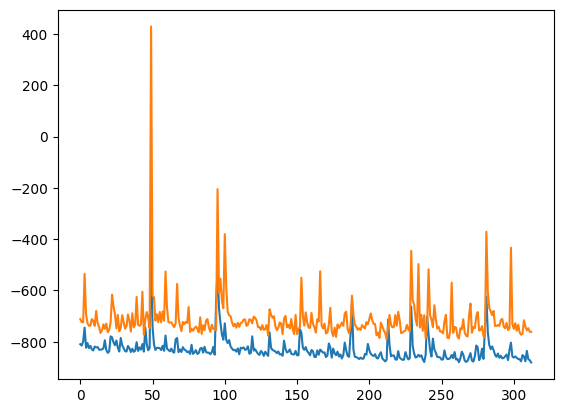

alpha 0.1 default_lr 0.0005


In [33]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [34]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [35]:
print(datetime.datetime.now())

2023-07-26 09:05:42.578838


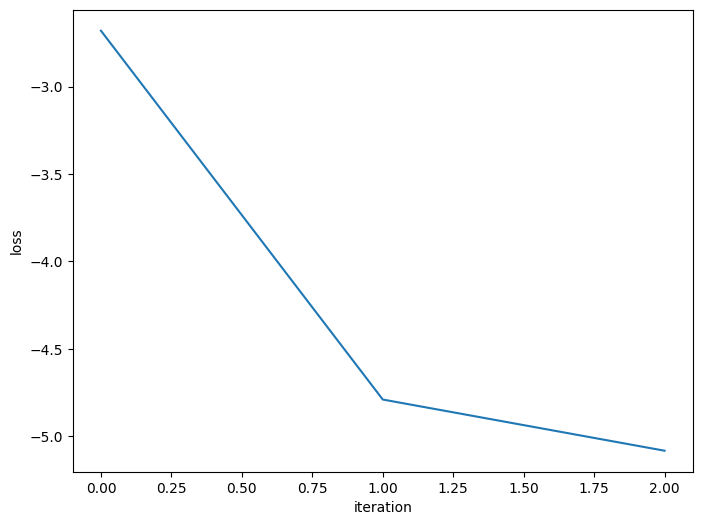

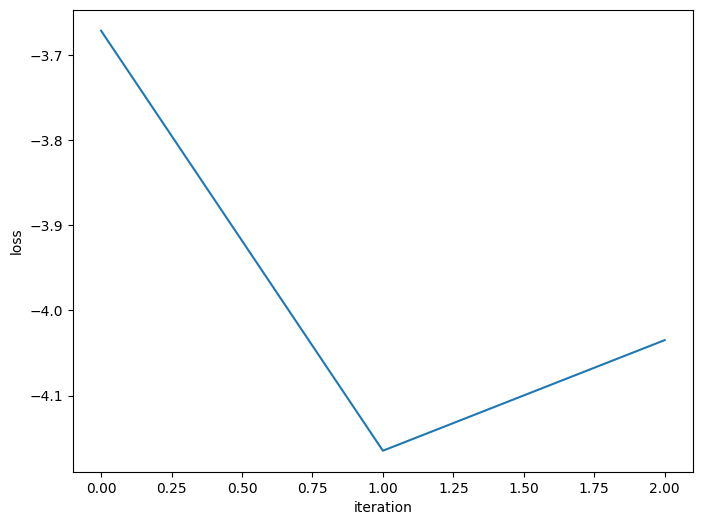

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# Iter 4

In [37]:
policy_evaluation_iter=3

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [-38.08155466   6.38558654 -65.83995859 -31.41267048] [ 0.36620743  0.36720027 -1.37503344 -1.76797934] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 198

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48
predict diverge [-13.78355484  13.91693196 -77.48491504 -31.17425819] [ 0.67052159  0.21290821 -1.41703374 -2.26770199] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 199

 49
predict diverge [-18.17336401   7.64830179 -84.41589128 -31.21782067] [ 0.54203853 -0.00350432 -1.7810722  -1.55502304] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 169

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61



In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.49542  validloss 0.54065±0.00000  bestvalidloss 0.54065  last_update 0
train: iter 1  trainloss 0.46614  validloss 0.48024±0.00000  bestvalidloss 0.48024  last_update 0
train: iter 2  trainloss 0.43594  validloss 0.46188±0.00000  bestvalidloss 0.46188  last_update 0
train: iter 3  trainloss 0.43422  validloss 0.45343±0.00000  bestvalidloss 0.45343  last_update 0
train: iter 4  trainloss 0.43105  validloss 0.45102±0.00000  bestvalidloss 0.45102  last_update 0
train: iter 5  trainloss 0.42877  validloss 0.43564±0.00000  bestvalidloss 0.43564  last_update 0
train: iter 6  trainloss 0.41740  validloss 0.43466±0.00000  bestvalidloss 0.43466  last_update 0
train: iter 7  trainloss 0.41654  validloss 0.43584±0.00000  bestvalidloss 0.43466  last_update 1
train: iter 8  trainloss 0.40860  validloss 0.43396±0.00000  bestvalidloss 0.43396  last_update 0
train: iter 9  trainloss 0.40707  validloss 0.43570±0.00000  bestvalidloss 0.43396  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.38046  validloss 0.42658±0.00000  bestvalidloss 0.41569  last_update 31
train: iter 84  trainloss 0.37790  validloss 0.42208±0.00000  bestvalidloss 0.41569  last_update 32
train: iter 85  trainloss 0.38113  validloss 0.41987±0.00000  bestvalidloss 0.41569  last_update 33
train: iter 86  trainloss 0.38188  validloss 0.42241±0.00000  bestvalidloss 0.41569  last_update 34
train: iter 87  trainloss 0.38683  validloss 0.41735±0.00000  bestvalidloss 0.41569  last_update 35
train: iter 88  trainloss 0.38157  validloss 0.43196±0.00000  bestvalidloss 0.41569  last_update 36
train: iter 89  trainloss 0.37635  validloss 0.41655±0.00000  bestvalidloss 0.41569  last_update 37
train: iter 90  trainloss 0.37311  validloss 0.42031±0.00000  bestvalidloss 0.41569  last_update 38
train: iter 91  trainloss 0.38980  validloss 0.42544±0.00000  bestvalidloss 0.41569  last_update 39
train: iter 92  trainloss 0.37948  validloss 0.42170±0.00000  bestvalidloss 0.41569  last_update 40


In [40]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.718788219344616
valid_loss:  -4.320230861020088
weight_alpha 1.0 h_min_tilde -11.59194 ell_tilde -4.63907674767971 kappa_tilde 0.00037924351083031774
train_loss:  -4.324962596225738
valid_loss:  -3.872277136230468
weight_alpha 0.1 h_min_tilde -11.59194 ell_tilde -4.234425504226684 kappa_tilde 0.0003686671477486748


In [41]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -843.21200  validloss -770.80330±0.00000  bestvalidloss -770.80330  last_update 0
train: iter 1  trainloss -864.40549  validloss -786.50167±0.00000  bestvalidloss -786.50167  last_update 0
train: iter 2  trainloss -837.30466  validloss -760.65476±0.00000  bestvalidloss -786.50167  last_update 1
train: iter 3  trainloss -837.27091  validloss -730.45345±0.00000  bestvalidloss -786.50167  last_update 2
train: iter 4  trainloss -866.87158  validloss -760.50789±0.00000  bestvalidloss -786.50167  last_update 3
train: iter 5  trainloss -844.89178  validloss -773.05125±0.00000  bestvalidloss -786.50167  last_update 4
train: iter 6  trainloss -824.71468  validloss -727.86663±0.00000  bestvalidloss -786.50167  last_update 5
train: iter 7  trainloss -846.39924  validloss -718.98449±0.00000  bestvalidloss -786.50167  last_update 6
train: iter 8  trainloss -856.26167  validloss -738.04653±0.00000  bestvalidloss -786.50167  last_u

train: iter 76  trainloss -856.56592  validloss -646.66797±0.00000  bestvalidloss -802.23165  last_update 39
train: iter 77  trainloss -874.39942  validloss -773.50501±0.00000  bestvalidloss -802.23165  last_update 40
train: iter 78  trainloss -852.05396  validloss -753.55674±0.00000  bestvalidloss -802.23165  last_update 41
train: iter 79  trainloss -864.08446  validloss -790.38436±0.00000  bestvalidloss -802.23165  last_update 42
train: iter 80  trainloss -830.70849  validloss 179.41239±0.00000  bestvalidloss -802.23165  last_update 43
train: iter 81  trainloss -866.15010  validloss -741.16013±0.00000  bestvalidloss -802.23165  last_update 44
train: iter 82  trainloss -880.14088  validloss -783.17658±0.00000  bestvalidloss -802.23165  last_update 45
train: iter 83  trainloss -837.66282  validloss -766.31479±0.00000  bestvalidloss -802.23165  last_update 46
train: iter 84  trainloss -861.84605  validloss -741.61582±0.00000  bestvalidloss -802.23165  last_update 47
train: iter 85  trai

train: iter 151  trainloss -882.65678  validloss -778.41948±0.00000  bestvalidloss -805.58255  last_update 7
train: iter 152  trainloss -755.27877  validloss -638.58857±0.00000  bestvalidloss -805.58255  last_update 8
train: iter 153  trainloss -834.70846  validloss -661.55281±0.00000  bestvalidloss -805.58255  last_update 9
train: iter 154  trainloss -860.42281  validloss -731.26772±0.00000  bestvalidloss -805.58255  last_update 10
train: iter 155  trainloss -870.04156  validloss -725.43745±0.00000  bestvalidloss -805.58255  last_update 11
train: iter 156  trainloss -874.17865  validloss -749.11547±0.00000  bestvalidloss -805.58255  last_update 12
train: iter 157  trainloss -870.85266  validloss -750.14996±0.00000  bestvalidloss -805.58255  last_update 13
train: iter 158  trainloss -876.57269  validloss -733.41751±0.00000  bestvalidloss -805.58255  last_update 14
train: iter 159  trainloss -868.20084  validloss -757.21518±0.00000  bestvalidloss -805.58255  last_update 15
train: iter 1

train: iter 226  trainloss -884.99016  validloss -651.66405±0.00000  bestvalidloss -805.58255  last_update 82
train: iter 227  trainloss -898.24326  validloss -756.38722±0.00000  bestvalidloss -805.58255  last_update 83
train: iter 228  trainloss -860.25531  validloss -684.79788±0.00000  bestvalidloss -805.58255  last_update 84
train: iter 229  trainloss -793.70831  validloss -641.87036±0.00000  bestvalidloss -805.58255  last_update 85
train: iter 230  trainloss -867.90361  validloss -759.60573±0.00000  bestvalidloss -805.58255  last_update 86
train: iter 231  trainloss -885.64851  validloss -767.35325±0.00000  bestvalidloss -805.58255  last_update 87
train: iter 232  trainloss -897.73380  validloss -805.48579±0.00000  bestvalidloss -805.58255  last_update 88
train: iter 233  trainloss -891.39471  validloss -794.72235±0.00000  bestvalidloss -805.58255  last_update 89
train: iter 234  trainloss -897.71185  validloss -762.53832±0.00000  bestvalidloss -805.58255  last_update 90
train: ite

train: iter 301  trainloss -876.27115  validloss -719.47575±0.00000  bestvalidloss -816.75256  last_update 9
train: iter 302  trainloss -879.20372  validloss -766.33008±0.00000  bestvalidloss -816.75256  last_update 10
train: iter 303  trainloss -895.43197  validloss -789.70809±0.00000  bestvalidloss -816.75256  last_update 11
train: iter 304  trainloss -895.12117  validloss -782.97410±0.00000  bestvalidloss -816.75256  last_update 12
train: iter 305  trainloss -884.52581  validloss -778.44571±0.00000  bestvalidloss -816.75256  last_update 13
train: iter 306  trainloss -897.17914  validloss -769.19827±0.00000  bestvalidloss -816.75256  last_update 14
train: iter 307  trainloss -900.23187  validloss -797.28900±0.00000  bestvalidloss -816.75256  last_update 15
train: iter 308  trainloss -656.70503  validloss -744.66377±0.00000  bestvalidloss -816.75256  last_update 16
train: iter 309  trainloss -845.38552  validloss -762.69073±0.00000  bestvalidloss -816.75256  last_update 17
train: iter

train: iter 376  trainloss -900.63300  validloss -782.56806±0.00000  bestvalidloss -842.42152  last_update 2
train: iter 377  trainloss -912.20370  validloss -784.33046±0.00000  bestvalidloss -842.42152  last_update 3
train: iter 378  trainloss -913.57244  validloss -813.40022±0.00000  bestvalidloss -842.42152  last_update 4
train: iter 379  trainloss -924.36215  validloss -810.52066±0.00000  bestvalidloss -842.42152  last_update 5
train: iter 380  trainloss -920.49347  validloss -841.28592±0.00000  bestvalidloss -842.42152  last_update 6
train: iter 381  trainloss -870.32639  validloss -757.51430±0.00000  bestvalidloss -842.42152  last_update 7
train: iter 382  trainloss -919.50911  validloss -795.11030±0.00000  bestvalidloss -842.42152  last_update 8
train: iter 383  trainloss -921.12111  validloss -810.21818±0.00000  bestvalidloss -842.42152  last_update 9
train: iter 384  trainloss -799.99643  validloss -824.29805±0.00000  bestvalidloss -842.42152  last_update 10
train: iter 385  t

train: iter 451  trainloss -924.65507  validloss -815.66359±0.00000  bestvalidloss -855.16828  last_update 27
train: iter 452  trainloss -894.94377  validloss -795.12178±0.00000  bestvalidloss -855.16828  last_update 28
train: iter 453  trainloss -926.01853  validloss -835.94784±0.00000  bestvalidloss -855.16828  last_update 29
train: iter 454  trainloss -909.56974  validloss -801.46800±0.00000  bestvalidloss -855.16828  last_update 30
train: iter 455  trainloss -927.33809  validloss -852.33746±0.00000  bestvalidloss -855.16828  last_update 31
train: iter 456  trainloss -943.35419  validloss -847.46203±0.00000  bestvalidloss -855.16828  last_update 32
train: iter 457  trainloss -933.88874  validloss -837.07827±0.00000  bestvalidloss -855.16828  last_update 33
train: iter 458  trainloss -905.72404  validloss -671.71851±0.00000  bestvalidloss -855.16828  last_update 34
train: iter 459  trainloss -928.83840  validloss -816.02539±0.00000  bestvalidloss -855.16828  last_update 35
train: ite

train: iter 526  trainloss -934.72460  validloss -821.94862±0.00000  bestvalidloss -870.48159  last_update 23
train: iter 527  trainloss -879.13041  validloss -741.21615±0.00000  bestvalidloss -870.48159  last_update 24
train: iter 528  trainloss -931.70107  validloss -796.65611±0.00000  bestvalidloss -870.48159  last_update 25
train: iter 529  trainloss -937.44602  validloss -803.95806±0.00000  bestvalidloss -870.48159  last_update 26
train: iter 530  trainloss -925.54066  validloss -816.47280±0.00000  bestvalidloss -870.48159  last_update 27
train: iter 531  trainloss -927.32528  validloss -840.83143±0.00000  bestvalidloss -870.48159  last_update 28
train: iter 532  trainloss -913.89766  validloss -828.14150±0.00000  bestvalidloss -870.48159  last_update 29
train: iter 533  trainloss -932.86765  validloss -831.43593±0.00000  bestvalidloss -870.48159  last_update 30
train: iter 534  trainloss -934.14259  validloss -809.24991±0.00000  bestvalidloss -870.48159  last_update 31
train: ite

train: iter 601  trainloss -917.96422  validloss -768.58977±0.00000  bestvalidloss -870.48159  last_update 98
train: iter 602  trainloss -933.52606  validloss -781.88743±0.00000  bestvalidloss -870.48159  last_update 99
train: iter 603  trainloss -923.98357  validloss -796.94507±0.00000  bestvalidloss -870.48159  last_update 100
train: fin
penalty_target_min tensor(-11.4859) penalty_target_max tensor(22.3638)


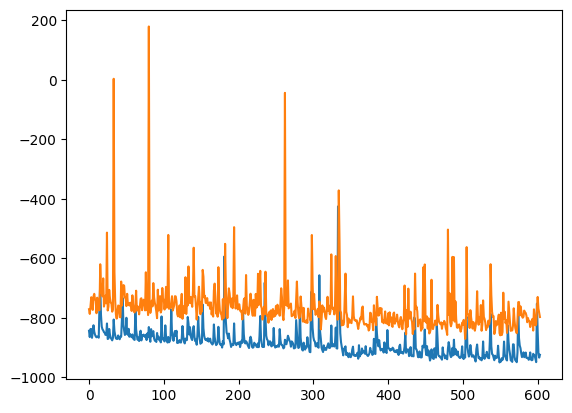

alpha 0.1 default_lr 0.0005


In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [43]:
print(datetime.datetime.now())

2023-07-26 09:33:21.351951


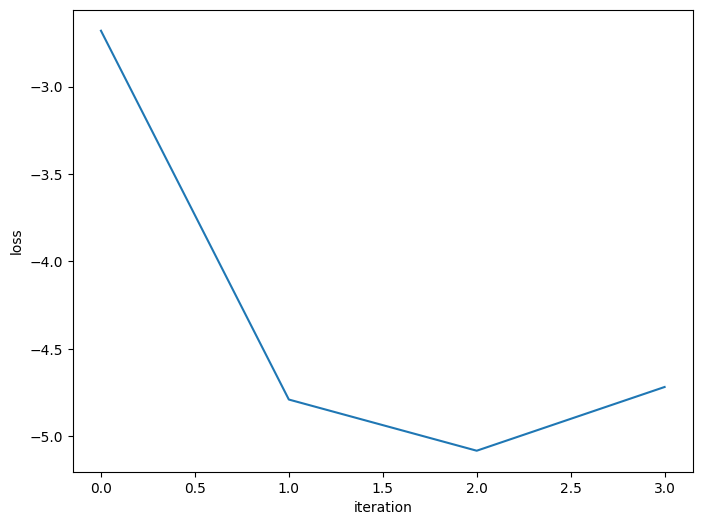

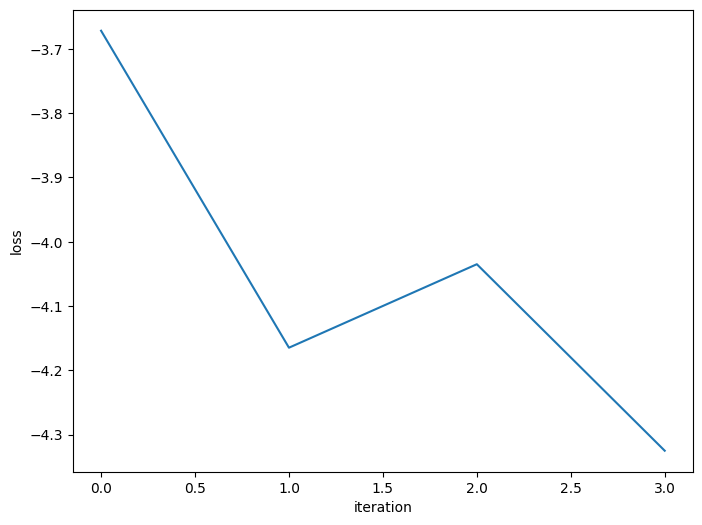

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# Iter 5

In [45]:
policy_evaluation_iter=4

In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-25.81376361 -17.57163549 -39.31043942  22.31830591] [-0.88314026 -0.80090235 -0.1895647   3.05429072] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 110

 2

 3

 4

 5

 6

 7
predict diverge [-21.91157024 -17.85846994 -31.73652679  24.567858  ] [-0.9055507  -1.03113836  0.29817598  2.91788169] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 90

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24
predict diverge [-23.0821328  -18.54781675 -28.13991899  29.79142457] [-0.99831715 -1.42276227  0.80031958  3.03462827] [ 91.41299   17.162447 204.38652   30.511166] [ 45.706493    8.5812235 102.19326    15.255583 ] sim_timestep 111

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40
predict diverge [-34.44578098 -18.3972425   17.30860759  29.74469831] [-1.03764628 -1.72573451  1.57311056 

In [47]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.54011  validloss 0.58508±0.00000  bestvalidloss 0.58508  last_update 0
train: iter 1  trainloss 0.49053  validloss 0.52165±0.00000  bestvalidloss 0.52165  last_update 0
train: iter 2  trainloss 0.48146  validloss 0.51244±0.00000  bestvalidloss 0.51244  last_update 0
train: iter 3  trainloss 0.46955  validloss 0.50102±0.00000  bestvalidloss 0.50102  last_update 0
train: iter 4  trainloss 0.46522  validloss 0.49740±0.00000  bestvalidloss 0.49740  last_update 0
train: iter 5  trainloss 0.46205  validloss 0.50934±0.00000  bestvalidloss 0.49740  last_update 1
train: iter 6  trainloss 0.46391  validloss 0.49380±0.00000  bestvalidloss 0.49380  last_update 0
train: iter 7  trainloss 0.45471  validloss 0.49292±0.00000  bestvalidloss 0.49292  last_update 0
train: iter 8  trainloss 0.46384  validloss 0.49538±0.00000  bestvalidloss 0.49292  last_update 1
train: iter 9  trainloss 0.45195  validloss 0.48642±0.00000  bestvalidloss 0.48642  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.41656  validloss 0.48294±0.00000  bestvalidloss 0.47095  last_update 22
train: iter 84  trainloss 0.42364  validloss 0.48827±0.00000  bestvalidloss 0.47095  last_update 23
train: iter 85  trainloss 0.41455  validloss 0.47648±0.00000  bestvalidloss 0.47095  last_update 24
train: iter 86  trainloss 0.41325  validloss 0.47749±0.00000  bestvalidloss 0.47095  last_update 25
train: iter 87  trainloss 0.41857  validloss 0.47667±0.00000  bestvalidloss 0.47095  last_update 26
train: iter 88  trainloss 0.41317  validloss 0.48931±0.00000  bestvalidloss 0.47095  last_update 27
train: iter 89  trainloss 0.41340  validloss 0.48137±0.00000  bestvalidloss 0.47095  last_update 28
train: iter 90  trainloss 0.41822  validloss 0.48826±0.00000  bestvalidloss 0.47095  last_update 29
train: iter 91  trainloss 0.41408  validloss 0.47858±0.00000  bestvalidloss 0.47095  last_update 30
train: iter 92  trainloss 0.41711  validloss 0.47863±0.00000  bestvalidloss 0.47095  last_update 31


train: iter 166  trainloss 0.40040  validloss 0.48909±0.00000  bestvalidloss 0.46665  last_update 62
train: iter 167  trainloss 0.39912  validloss 0.49297±0.00000  bestvalidloss 0.46665  last_update 63
train: iter 168  trainloss 0.40034  validloss 0.48237±0.00000  bestvalidloss 0.46665  last_update 64
train: iter 169  trainloss 0.40085  validloss 0.49705±0.00000  bestvalidloss 0.46665  last_update 65
train: iter 170  trainloss 0.39706  validloss 0.47536±0.00000  bestvalidloss 0.46665  last_update 66
train: iter 171  trainloss 0.40213  validloss 0.47310±0.00000  bestvalidloss 0.46665  last_update 67
train: iter 172  trainloss 0.39878  validloss 0.47532±0.00000  bestvalidloss 0.46665  last_update 68
train: iter 173  trainloss 0.40455  validloss 0.49102±0.00000  bestvalidloss 0.46665  last_update 69
train: iter 174  trainloss 0.40222  validloss 0.48467±0.00000  bestvalidloss 0.46665  last_update 70
train: iter 175  trainloss 0.40248  validloss 0.48324±0.00000  bestvalidloss 0.46665  last_

In [48]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -5.951655618447065
valid_loss:  -6.427246911907195
weight_alpha 1.0 h_min_tilde -11.485944 ell_tilde -6.046773877139091 kappa_tilde 0.0004287791775471494
train_loss:  -4.427305310535432
valid_loss:  -4.062526027488708
weight_alpha 0.1 h_min_tilde -11.485944 ell_tilde -4.354349453926087 kappa_tilde 0.0003744610788289408


In [49]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -887.99820  validloss -811.73431±0.00000  bestvalidloss -811.73431  last_update 0
train: iter 1  trainloss -881.33845  validloss -789.07492±0.00000  bestvalidloss -811.73431  last_update 1
train: iter 2  trainloss -894.08190  validloss -830.14856±0.00000  bestvalidloss -830.14856  last_update 0
train: iter 3  trainloss -872.48776  validloss -725.49723±0.00000  bestvalidloss -830.14856  last_update 1
train: iter 4  trainloss -904.67708  validloss -813.83577±0.00000  bestvalidloss -830.14856  last_update 2
train: iter 5  trainloss -828.79806  validloss -725.39059±0.00000  bestvalidloss -830.14856  last_update 3
train: iter 6  trainloss -888.00988  validloss -787.40593±0.00000  bestvalidloss -830.14856  last_update 4
train: iter 7  trainloss -896.61198  validloss -842.59611±0.00000  bestvalidloss -842.59611  last_update 0
train: iter 8  trainloss -894.89039  validloss -808.74830±0.00000  bestvalidloss -842.59611  last_u

train: iter 76  trainloss -899.97722  validloss -829.22344±0.00000  bestvalidloss -863.84074  last_update 32
train: iter 77  trainloss -878.19199  validloss -812.61787±0.00000  bestvalidloss -863.84074  last_update 33
train: iter 78  trainloss -902.28608  validloss -812.50077±0.00000  bestvalidloss -863.84074  last_update 34
train: iter 79  trainloss -897.87627  validloss -812.83288±0.00000  bestvalidloss -863.84074  last_update 35
train: iter 80  trainloss -896.37488  validloss -824.70158±0.00000  bestvalidloss -863.84074  last_update 36
train: iter 81  trainloss -868.38796  validloss -848.78621±0.00000  bestvalidloss -863.84074  last_update 37
train: iter 82  trainloss -872.02304  validloss -535.80656±0.00000  bestvalidloss -863.84074  last_update 38
train: iter 83  trainloss -897.62876  validloss -818.16026±0.00000  bestvalidloss -863.84074  last_update 39
train: iter 84  trainloss -903.81981  validloss -820.13584±0.00000  bestvalidloss -863.84074  last_update 40
train: iter 85  tra

train: iter 151  trainloss -873.93607  validloss -620.51112±0.00000  bestvalidloss -867.86223  last_update 13
train: iter 152  trainloss -904.65110  validloss -792.89081±0.00000  bestvalidloss -867.86223  last_update 14
train: iter 153  trainloss -902.83811  validloss -801.58251±0.00000  bestvalidloss -867.86223  last_update 15
train: iter 154  trainloss -906.43972  validloss -830.31167±0.00000  bestvalidloss -867.86223  last_update 16
train: iter 155  trainloss -910.83646  validloss -830.70593±0.00000  bestvalidloss -867.86223  last_update 17
train: iter 156  trainloss -911.47138  validloss -866.56281±0.00000  bestvalidloss -867.86223  last_update 18
train: iter 157  trainloss -896.09070  validloss -828.91439±0.00000  bestvalidloss -867.86223  last_update 19
train: iter 158  trainloss -894.96242  validloss -787.38171±0.00000  bestvalidloss -867.86223  last_update 20
train: iter 159  trainloss -899.23903  validloss -858.49531±0.00000  bestvalidloss -867.86223  last_update 21
train: ite

train: iter 226  trainloss -883.90791  validloss -798.83562±0.00000  bestvalidloss -873.83528  last_update 55
train: iter 227  trainloss -906.59525  validloss -816.15666±0.00000  bestvalidloss -873.83528  last_update 56
train: iter 228  trainloss -868.40365  validloss -819.39697±0.00000  bestvalidloss -873.83528  last_update 57
train: iter 229  trainloss -894.36389  validloss -787.53082±0.00000  bestvalidloss -873.83528  last_update 58
train: iter 230  trainloss -906.86427  validloss -806.64083±0.00000  bestvalidloss -873.83528  last_update 59
train: iter 231  trainloss -909.39210  validloss -802.99503±0.00000  bestvalidloss -873.83528  last_update 60
train: iter 232  trainloss -876.24435  validloss -774.65078±0.00000  bestvalidloss -873.83528  last_update 61
train: iter 233  trainloss -911.61891  validloss -813.69051±0.00000  bestvalidloss -873.83528  last_update 62
train: iter 234  trainloss -909.63187  validloss -835.70135±0.00000  bestvalidloss -873.83528  last_update 63
train: ite

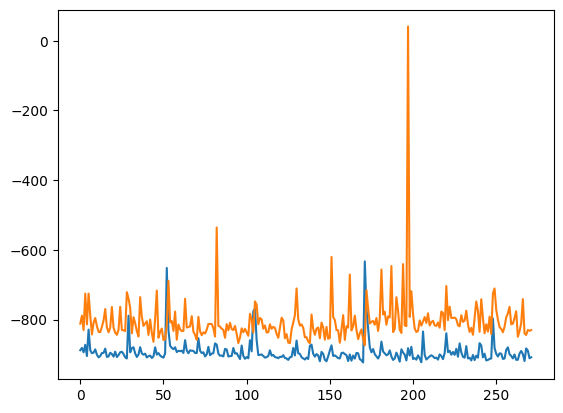

alpha 0.1 default_lr 0.0005


In [50]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [51]:
print(datetime.datetime.now())

2023-07-26 09:57:05.114732


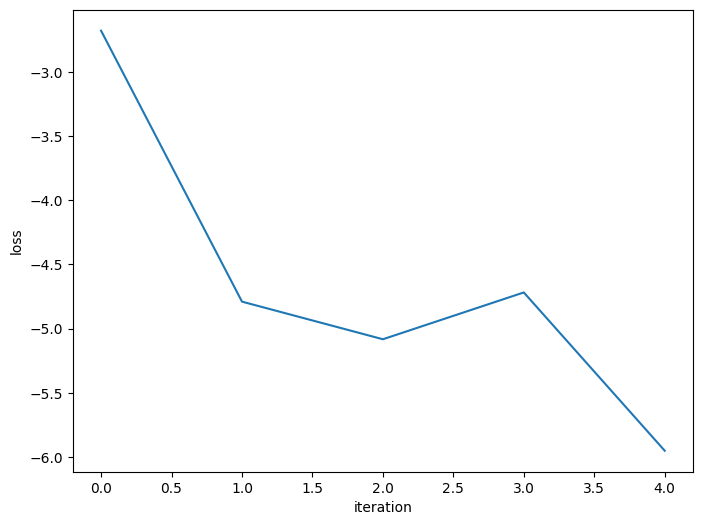

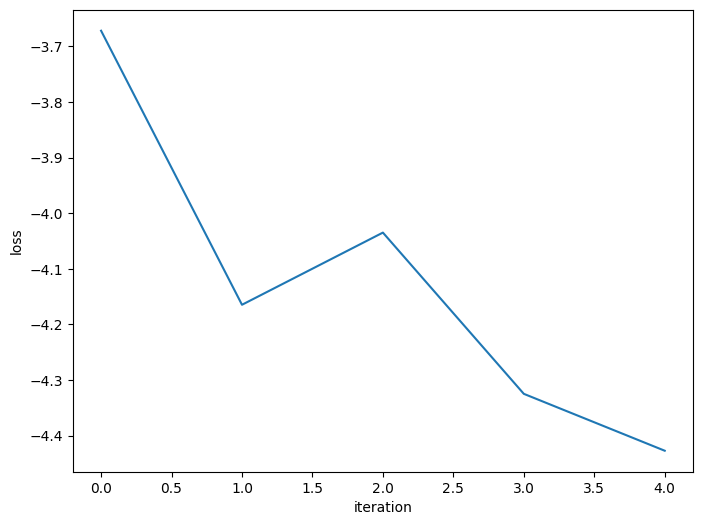

In [52]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

# 評価関数計算

In [53]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [54]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.49535  validloss 0.49829±0.00000  bestvalidloss 0.49829  last_update 0
train: iter 1  trainloss 0.45672  validloss 0.46694±0.00000  bestvalidloss 0.46694  last_update 0
train: iter 2  trainloss 0.44418  validloss 0.49473±0.00000  bestvalidloss 0.46694  last_update 1
train: iter 3  trainloss 0.43909  validloss 0.46519±0.00000  bestvalidloss 0.46519  last_update 0
train: iter 4  trainloss 0.43437  validloss 0.47093±0.00000  bestvalidloss 0.46519  last_update 1
train: iter 5  trainloss 0.42842  validloss 0.47179±0.00000  bestvalidloss 0.46519  last_update 2
train: iter 6  trainloss 0.43091  validloss 0.46873±0.00000  bestvalidloss 0.46519  last_update 3
train: iter 7  trainloss 0.42841  validloss 0.46363±0.00000  bestvalidloss 0.46363  last_update 0
train: iter 8  trainloss 0.43680  validloss 0.47402±0.00000  bestvalidloss 0.46363  last_update 1
train: iter 9  trainloss 0.42208  validloss 0.46727±0.00000  bestvalidloss 0.46363  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.40380  validloss 0.50218±0.00000  bestvalidloss 0.46363  last_update 76
train: iter 84  trainloss 0.40180  validloss 0.47658±0.00000  bestvalidloss 0.46363  last_update 77
train: iter 85  trainloss 0.39447  validloss 0.47646±0.00000  bestvalidloss 0.46363  last_update 78
train: iter 86  trainloss 0.39541  validloss 0.47746±0.00000  bestvalidloss 0.46363  last_update 79
train: iter 87  trainloss 0.39638  validloss 0.47659±0.00000  bestvalidloss 0.46363  last_update 80
train: iter 88  trainloss 0.39480  validloss 0.46943±0.00000  bestvalidloss 0.46363  last_update 81
train: iter 89  trainloss 0.40203  validloss 0.47613±0.00000  bestvalidloss 0.46363  last_update 82
train: iter 90  trainloss 0.39566  validloss 0.49874±0.00000  bestvalidloss 0.46363  last_update 83
train: iter 91  trainloss 0.39406  validloss 0.47413±0.00000  bestvalidloss 0.46363  last_update 84
train: iter 92  trainloss 0.39777  validloss 0.47588±0.00000  bestvalidloss 0.46363  last_update 85


train: iter 165  trainloss 0.38325  validloss 0.47952±0.00000  bestvalidloss 0.46280  last_update 71
train: iter 166  trainloss 0.39274  validloss 0.47015±0.00000  bestvalidloss 0.46280  last_update 72
train: iter 167  trainloss 0.38944  validloss 0.50442±0.00000  bestvalidloss 0.46280  last_update 73
train: iter 168  trainloss 0.38626  validloss 0.47919±0.00000  bestvalidloss 0.46280  last_update 74
train: iter 169  trainloss 0.38590  validloss 0.48443±0.00000  bestvalidloss 0.46280  last_update 75
train: iter 170  trainloss 0.38431  validloss 0.47713±0.00000  bestvalidloss 0.46280  last_update 76
train: iter 171  trainloss 0.38388  validloss 0.47435±0.00000  bestvalidloss 0.46280  last_update 77
train: iter 172  trainloss 0.38152  validloss 0.46811±0.00000  bestvalidloss 0.46280  last_update 78
train: iter 173  trainloss 0.38445  validloss 0.46946±0.00000  bestvalidloss 0.46280  last_update 79
train: iter 174  trainloss 0.38717  validloss 0.47467±0.00000  bestvalidloss 0.46280  last_

([0.4953494004905224,
  0.45672259069979193,
  0.4441832983866334,
  0.4390856113284826,
  0.4343696186318994,
  0.4284150548279285,
  0.43091478999704125,
  0.4284065367653966,
  0.4367979161441326,
  0.42207882963120935,
  0.43970874007791283,
  0.4234138889238238,
  0.42305704709142444,
  0.41637517968192694,
  0.4193030010908842,
  0.4181285066530108,
  0.4170863673090935,
  0.4174367253668606,
  0.41523499954491855,
  0.41373684611171485,
  0.417342204041779,
  0.414091769605875,
  0.42182261496782303,
  0.42678996697068217,
  0.419986514095217,
  0.41235427986830475,
  0.4110804956406355,
  0.4158186227083206,
  0.4127889322116971,
  0.41060208091512324,
  0.41314319130033256,
  0.4143400713801384,
  0.41077958680689336,
  0.419207854103297,
  0.408419187925756,
  0.4148691775277257,
  0.4087781259790063,
  0.412662610784173,
  0.40995268188416956,
  0.4133398706093431,
  0.41388390492647886,
  0.402857565972954,
  0.40368896620348094,
  0.4089232487604022,
  0.41098364079371097,

In [55]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.929069126808643
valid_loss:  -5.526125964498521
weight_alpha 1.0 h_min_tilde -11.705451 ell_tilde -5.0484804943466175 kappa_tilde 0.0003875802899069334
train_loss:  -4.476031409740447
valid_loss:  -4.057063299942016
weight_alpha 0.1 h_min_tilde -11.705451 ell_tilde -4.39223778778076 kappa_tilde 0.00036978209792855126


In [56]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 46.62982  validloss 50.07522±0.00000  bestvalidloss 50.07522  last_update 0
train: iter 1  trainloss 39.34208  validloss 42.52602±0.00000  bestvalidloss 42.52602  last_update 0
train: iter 2  trainloss 33.51701  validloss 35.67894±0.00000  bestvalidloss 35.67894  last_update 0
train: iter 3  trainloss 28.71554  validloss 30.49441±0.00000  bestvalidloss 30.49441  last_update 0
train: iter 4  trainloss 24.79153  validloss 26.12870±0.00000  bestvalidloss 26.12870  last_update 0
train: iter 5  trainloss 21.55643  validloss 22.63004±0.00000  bestvalidloss 22.63004  last_update 0
train: iter 6  trainloss 18.77861  validloss 19.75748±0.00000  bestvalidloss 19.75748  last_update 0
train: iter 7  trainloss 16.55871  validloss 17.02047±0.00000  bestvalidloss 17.02047  last_update 0
train: iter 8  trainloss 14.44917  validloss 15.04764±0.00000  bestvalidloss 15.04764  last_update 0
train: iter 9  trainloss 12.64758  validloss 13.11847±0.00000  bestvalidloss 13.11847  last

train: iter 95  trainloss 0.03843  validloss -0.15821±0.00000  bestvalidloss -0.16866  last_update 1
train: iter 96  trainloss 0.02541  validloss -0.22647±0.00000  bestvalidloss -0.22647  last_update 0
train: iter 97  trainloss 0.01825  validloss -0.24083±0.00000  bestvalidloss -0.24083  last_update 0
train: iter 98  trainloss -0.00914  validloss -0.23085±0.00000  bestvalidloss -0.24083  last_update 1
train: iter 99  trainloss -0.04690  validloss -0.27908±0.00000  bestvalidloss -0.27908  last_update 0
train: iter 100  trainloss -0.01953  validloss -0.26526±0.00000  bestvalidloss -0.27908  last_update 1
train: iter 101  trainloss -0.05959  validloss -0.28845±0.00000  bestvalidloss -0.28845  last_update 0
train: iter 102  trainloss -0.07772  validloss -0.33520±0.00000  bestvalidloss -0.33520  last_update 0
train: iter 103  trainloss -0.07853  validloss -0.38419±0.00000  bestvalidloss -0.38419  last_update 0
train: iter 104  trainloss -0.11019  validloss -0.35897±0.00000  bestvalidloss -0

train: iter 180  trainloss -0.36375  validloss -0.70998±0.00000  bestvalidloss -0.82784  last_update 4
train: iter 181  trainloss -0.37396  validloss -0.72419±0.00000  bestvalidloss -0.82784  last_update 5
train: iter 182  trainloss -0.38332  validloss -0.63537±0.00000  bestvalidloss -0.82784  last_update 6
train: iter 183  trainloss -0.41978  validloss -0.70228±0.00000  bestvalidloss -0.82784  last_update 7
train: iter 184  trainloss -0.40742  validloss -0.79508±0.00000  bestvalidloss -0.82784  last_update 8
train: iter 185  trainloss -0.33246  validloss -0.73342±0.00000  bestvalidloss -0.82784  last_update 9
train: iter 186  trainloss -0.33054  validloss -0.72457±0.00000  bestvalidloss -0.82784  last_update 10
train: iter 187  trainloss -0.37111  validloss -0.68527±0.00000  bestvalidloss -0.82784  last_update 11
train: iter 188  trainloss -0.32092  validloss -0.84874±0.00000  bestvalidloss -0.84874  last_update 0
train: iter 189  trainloss -0.32552  validloss -0.81370±0.00000  bestva

train: iter 265  trainloss -0.40028  validloss -0.75173±0.00000  bestvalidloss -0.84874  last_update 77
train: iter 266  trainloss -0.36322  validloss -0.81430±0.00000  bestvalidloss -0.84874  last_update 78
train: iter 267  trainloss -0.36313  validloss -0.78553±0.00000  bestvalidloss -0.84874  last_update 79
train: iter 268  trainloss -0.37471  validloss -0.82453±0.00000  bestvalidloss -0.84874  last_update 80
train: iter 269  trainloss -0.29596  validloss -0.62949±0.00000  bestvalidloss -0.84874  last_update 81
train: iter 270  trainloss -0.33550  validloss -0.70819±0.00000  bestvalidloss -0.84874  last_update 82
train: iter 271  trainloss -0.27286  validloss -0.75312±0.00000  bestvalidloss -0.84874  last_update 83
train: iter 272  trainloss -0.39581  validloss -0.70000±0.00000  bestvalidloss -0.84874  last_update 84
train: iter 273  trainloss -0.34876  validloss -0.69810±0.00000  bestvalidloss -0.84874  last_update 85
train: iter 274  trainloss -0.39078  validloss -0.82240±0.00000 

In [57]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-1.8831, -0.0156, -5.4043, -1.0052], requires_grad=True)


In [58]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 9.20475  validloss 18.47175±0.00000  bestvalidloss 18.47175  last_update 0
train: iter 1  trainloss 8.07737  validloss 19.42178±0.00000  bestvalidloss 18.47175  last_update 1
train: iter 2  trainloss 7.86237  validloss 17.89723±0.00000  bestvalidloss 17.89723  last_update 0
train: iter 3  trainloss 7.62482  validloss 18.24530±0.00000  bestvalidloss 17.89723  last_update 1
train: iter 4  trainloss 7.63122  validloss 17.04367±0.00000  bestvalidloss 17.04367  last_update 0
train: iter 5  trainloss 7.49069  validloss 17.18801±0.00000  bestvalidloss 17.04367  last_update 1
train: iter 6  trainloss 7.43611  validloss 17.89906±0.00000  bestvalidloss 17.04367  last_update 2
train: iter 7  trainloss 7.40650  validloss 17.60618±0.00000  bestvalidloss 17.04367  last_update 3
train: iter 8  trainloss 7.34888  validloss 17.36246±0.00000  bestvalidloss 17.04367  last_update 4
train: iter 9  trainloss 7.32202  validloss 18.20708±0.00000  bestvalidloss 17.04367  last_update 5


train: iter 82  trainloss 6.05027  validloss 15.94820±0.00000  bestvalidloss 14.86619  last_update 37
train: iter 83  trainloss 6.07181  validloss 17.53701±0.00000  bestvalidloss 14.86619  last_update 38
train: iter 84  trainloss 6.04552  validloss 15.96432±0.00000  bestvalidloss 14.86619  last_update 39
train: iter 85  trainloss 6.02220  validloss 15.93283±0.00000  bestvalidloss 14.86619  last_update 40
train: iter 86  trainloss 6.03257  validloss 16.11468±0.00000  bestvalidloss 14.86619  last_update 41
train: iter 87  trainloss 6.04954  validloss 16.73613±0.00000  bestvalidloss 14.86619  last_update 42
train: iter 88  trainloss 5.99907  validloss 16.26819±0.00000  bestvalidloss 14.86619  last_update 43
train: iter 89  trainloss 6.03148  validloss 16.61258±0.00000  bestvalidloss 14.86619  last_update 44
train: iter 90  trainloss 6.04548  validloss 15.54412±0.00000  bestvalidloss 14.86619  last_update 45
train: iter 91  trainloss 6.00710  validloss 16.35844±0.00000  bestvalidloss 14.86

train: iter 163  trainloss 5.92246  validloss 16.95394±0.00000  bestvalidloss 14.47091  last_update 25
train: iter 164  trainloss 5.89235  validloss 16.76469±0.00000  bestvalidloss 14.47091  last_update 26
train: iter 165  trainloss 5.74915  validloss 16.75695±0.00000  bestvalidloss 14.47091  last_update 27
train: iter 166  trainloss 5.88961  validloss 15.43869±0.00000  bestvalidloss 14.47091  last_update 28
train: iter 167  trainloss 5.83653  validloss 15.72940±0.00000  bestvalidloss 14.47091  last_update 29
train: iter 168  trainloss 5.77979  validloss 15.22607±0.00000  bestvalidloss 14.47091  last_update 30
train: iter 169  trainloss 5.83516  validloss 16.49891±0.00000  bestvalidloss 14.47091  last_update 31
train: iter 170  trainloss 5.86977  validloss 15.20845±0.00000  bestvalidloss 14.47091  last_update 32
train: iter 171  trainloss 5.87019  validloss 17.12654±0.00000  bestvalidloss 14.47091  last_update 33
train: iter 172  trainloss 5.88302  validloss 15.23985±0.00000  bestvalid

train: iter 243  trainloss 5.75339  validloss 14.94759±0.00000  bestvalidloss 14.41444  last_update 47
train: iter 244  trainloss 5.72984  validloss 15.36654±0.00000  bestvalidloss 14.41444  last_update 48
train: iter 245  trainloss 5.74276  validloss 16.36799±0.00000  bestvalidloss 14.41444  last_update 49
train: iter 246  trainloss 5.78758  validloss 15.89166±0.00000  bestvalidloss 14.41444  last_update 50
train: iter 247  trainloss 5.70139  validloss 16.69988±0.00000  bestvalidloss 14.41444  last_update 51
train: iter 248  trainloss 5.79668  validloss 15.90605±0.00000  bestvalidloss 14.41444  last_update 52
train: iter 249  trainloss 5.67172  validloss 16.28545±0.00000  bestvalidloss 14.41444  last_update 53
train: iter 250  trainloss 5.69916  validloss 15.43303±0.00000  bestvalidloss 14.41444  last_update 54
train: iter 251  trainloss 5.77985  validloss 15.97590±0.00000  bestvalidloss 14.41444  last_update 55
train: iter 252  trainloss 5.65812  validloss 16.50690±0.00000  bestvalid

In [59]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-8.3081)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(17.5616)


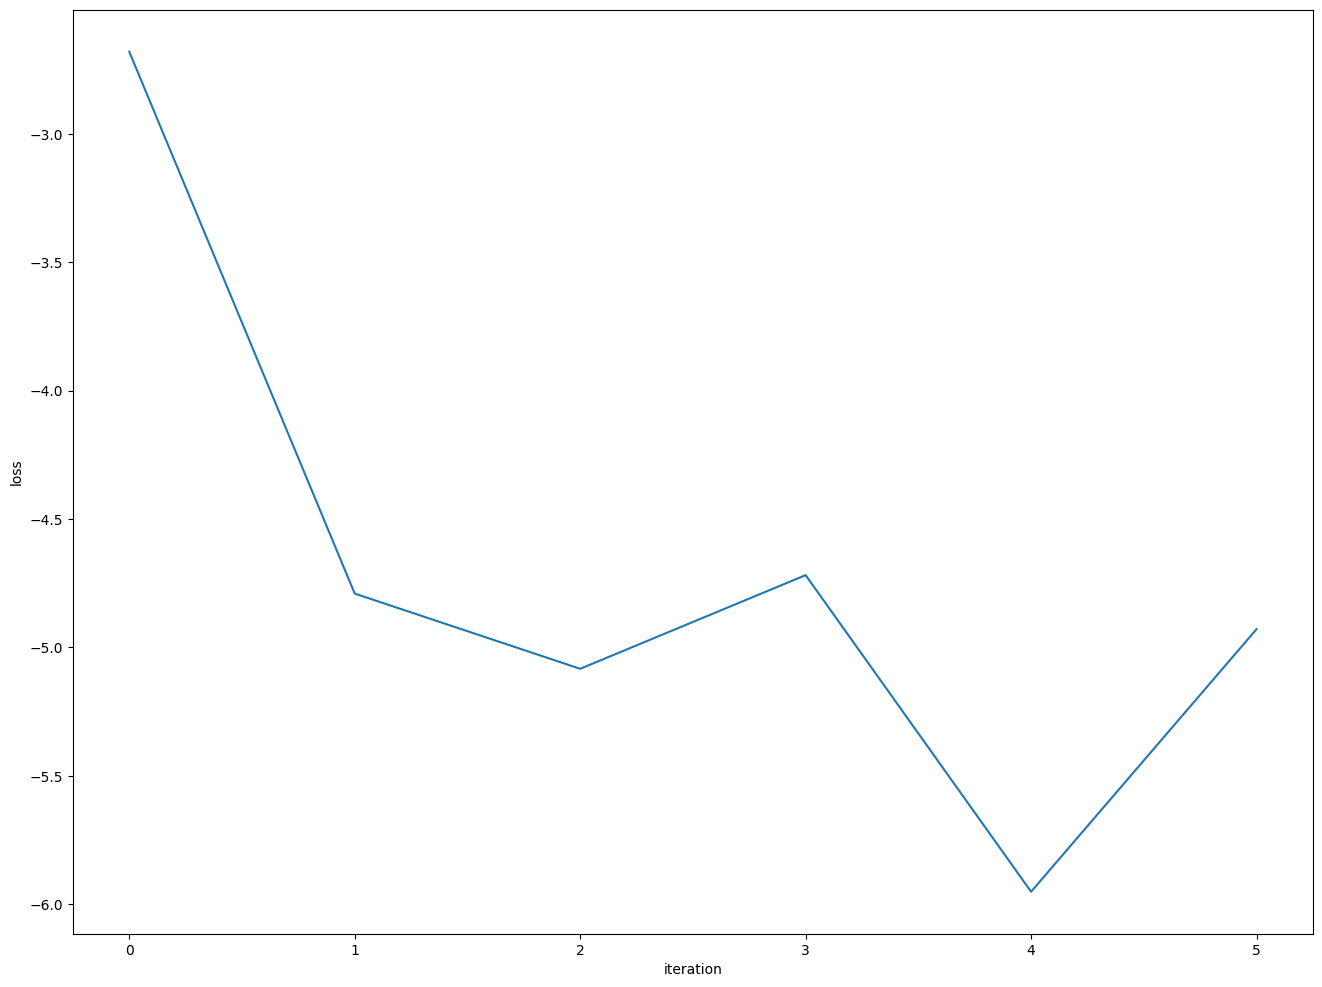

In [60]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

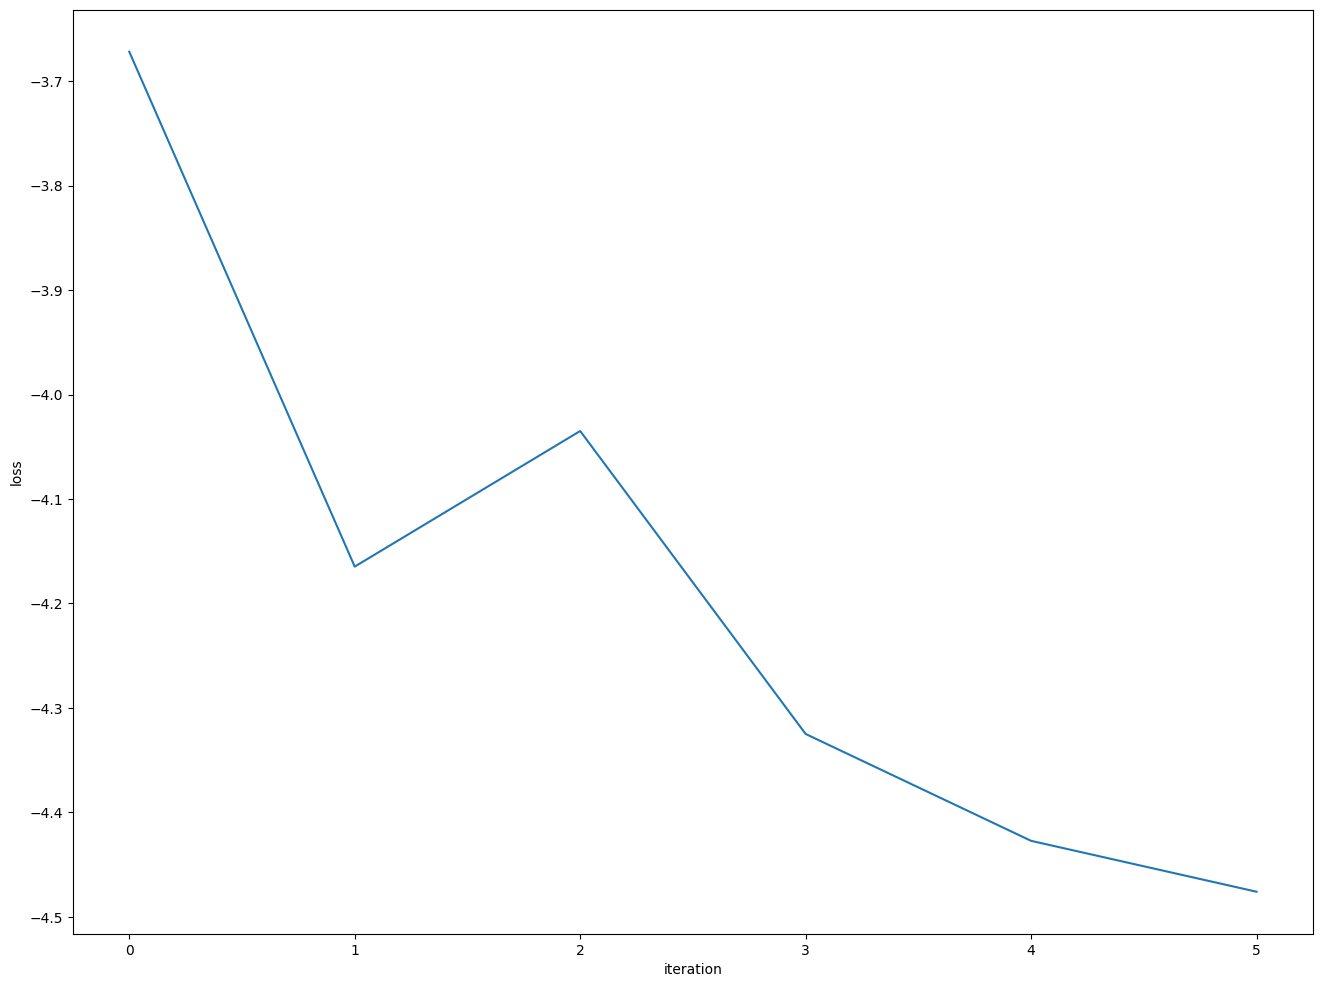

In [61]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")